# Importing Required Libraries

In [1]:
# Basic libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import math
import csv
import sys
import time

# RDKit for molecular descriptors
from rdkit import Chem
from rdkit.Chem import Descriptors

# Preprocessing and modeling
from sklearn.model_selection import train_test_split, RepeatedKFold, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.inspection import permutation_importance

# Machine Learning Models
from sklearn import linear_model, svm, neural_network, ensemble
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor


# Importing Dataset

In [2]:
import pandas as pd

url = "https://raw.githubusercontent.com/yus11x11/Machine-Learning-models-for-predicting-enthalpy-of-vaporization-from-molecular-descriptors/main/dataset.csv"
data = pd.read_csv(url)

In [3]:
data["Family"].value_counts()

Family
Hydrocarbons                        452
Benzenoids                          426
Lipids and lipid-like molecules     371
Organic oxygen compounds            319
Organoheterocyclic compounds        240
Organohalogen compounds             206
Organic acids and derivatives       150
Organic nitrogen compounds          127
Organosulfur compounds               68
Organic 1,3-dipolar compounds        20
Phenylpropanoids and polyketides     13
Acetylides                            6
Other                                 5
Allenes                               3
Organophosphorus compounds            3
Homogeneous non-metal compounds       1
Name: count, dtype: int64

In [4]:
data.isna().sum()

CAS         0
VOC         0
dvap        0
num         0
External    0
SMILES      0
Key         0
Family      0
dtype: int64

In [5]:
for column in data.columns:
    print(column)

CAS
VOC
dvap
num
External
SMILES
Key
Family


## Getting Deciptors from Rdkit 

In [6]:


descriptor_tuples = Descriptors._descList
my_descriptors = [name for name, function in descriptor_tuples]

# 2. Define a function to calculate descriptors for one SMILES string
def calculate_descriptors(smiles):
    """
    Calculates a list of RDKit descriptors for a given SMILES string.
    Returns a dictionary of {descriptor_name: value}.
    """
    mol = Chem.MolFromSmiles(smiles, sanitize=True)
    
    # Handle cases where SMILES is invalid
    if mol is None:
        return {desc: None for desc in my_descriptors}

    results = {}
    for desc in my_descriptors:
        # Use getattr() - it's safer and cleaner than eval()
        try:
            results[desc] = getattr(Descriptors, desc)(mol)
        except Exception:
            results[desc] = None # Handle calculation errors
    return results


print("Calculating descriptors...")
descriptor_series = data['SMILES'].apply(calculate_descriptors)

# 4. Convert the Series of dictionaries into a new DataFrame
# .tolist() converts the Series to a list of dicts, which pd.DataFrame handles
descriptor_df = pd.DataFrame(descriptor_series.tolist(), index=data.index)

final_data=pd.concat([data, descriptor_df], axis=1)
# final_data.drop(columns=["Ipc"], inplace=True)


Calculating descriptors...


In [7]:
exclude_cols = ['CAS', 'VOC', 'dvap', 'num', 'External', 'SMILES', 'Key', 'Family','dvap_log','dvap_scaled']
X_names = [col for col in final_data.columns if col not in exclude_cols]
data = final_data.dropna().reset_index(drop=True)  # Drop
data = final_data[X_names + ['dvap']]

## pca for feature



In [8]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# --- Load your dataset ---
# Example: df = pd.read_csv('your_data.csv')
# Assume last column is the target variable
X = data.drop(columns=['dvap'])      # 216 feature columns
y = data['dvap']        # target variable (integer over a range)

# --- Standardize features (important for PCA) ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# --- Fit PCA ---
pca = PCA()
pca.fit(X_scaled)

# --- Compute feature importance based on loadings ---
# Each feature's importance = sum of squared loadings across components (weighted by explained variance)
loadings = np.abs(pca.components_) * pca.explained_variance_ratio_[:, np.newaxis]
feature_importance = loadings.sum(axis=0)

# --- Select top 20 original features ---
top20_indices = np.argsort(feature_importance)[::-1][:30]
top20_features = X.columns[top20_indices].tolist()

print("Top 20 most important original features (by PCA):")
print(top20_features)


Top 20 most important original features (by PCA):
['PEOE_VSA2', 'EState_VSA3', 'qed', 'FpDensityMorgan3', 'FpDensityMorgan1', 'BCUT2D_MWLOW', 'SlogP_VSA3', 'BCUT2D_LOGPLOW', 'BalabanJ', 'VSA_EState2', 'BCUT2D_MRLOW', 'VSA_EState4', 'fr_ester', 'BCUT2D_CHGLO', 'EState_VSA8', 'BCUT2D_CHGHI', 'FpDensityMorgan2', 'PEOE_VSA9', 'EState_VSA2', 'fr_C_O', 'fr_ether', 'fr_C_O_noCOO', 'BCUT2D_LOGPHI', 'PEOE_VSA8', 'EState_VSA6', 'VSA_EState5', 'MinAbsPartialCharge', 'SlogP_VSA4', 'PEOE_VSA10', 'VSA_EState8']


In [9]:
data.shape

(2410, 218)

In [11]:
# top 100 features based on mutual information
useful_cols = top20_features

In [12]:
final_data = final_data[useful_cols + ['dvap']]

In [13]:
final_data.shape

(2410, 31)

## Scalling and feature Engineering

<Axes: ylabel='Frequency'>

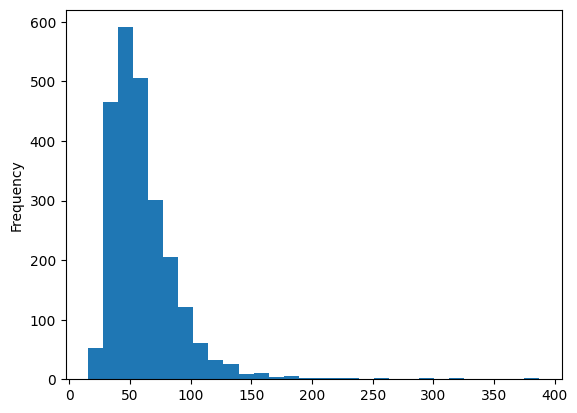

In [14]:
final_data["dvap"].plot.hist(bins=30)

In [15]:

final_data["dvap"] = final_data["dvap"].clip(lower=final_data["dvap"].quantile(0.01),
                                 upper=final_data["dvap"].quantile(0.99))

final_data["dvap_log"] = np.log1p(final_data["dvap"])
#plot historgram using plotly
import plotly.express as px
fig = px.histogram(final_data, x="dvap_log", nbins=30, title="Histogram of dvap_log after clipping")
fig.show()

# final_data["dvap_log"].plot.hist(bins=30)
# scaler = StandardScaler()
# final_data["dvap_scaled"] = scaler.fit_transform(final_data[["dvap"]])


In [16]:
import plotly.express as px
fig = px.histogram(final_data, x="dvap", nbins=30, title="Histogram of dvap after clipping")
fig.show()

In [17]:
skewness_log = final_data["dvap_log"].skew()
skewnes_normal = final_data["dvap"].skew()
print(f"Skewness of dvap: {skewnes_normal:.4f}")
print(f"Skewness of dvap_log: {skewness_log:.4f}")

Skewness of dvap: 1.7818
Skewness of dvap_log: 0.4877


In [18]:
final_data.shape

(2410, 32)

In [19]:
# # Select only numerical columns
numeric_cols = final_data.select_dtypes(include=['number']).columns

# # Plot histograms
# final_data[numeric_cols].hist(figsize=(15, 12), bins=30, edgecolor='black')
# plt.suptitle("Histograms of Numerical Columns", fontsize=16)
# plt.tight_layout()
# plt.show()

In [20]:
scaler1 = StandardScaler()
final_data_scaled = final_data.copy()
final_data_scaled[numeric_cols] = scaler.fit_transform(final_data[numeric_cols])

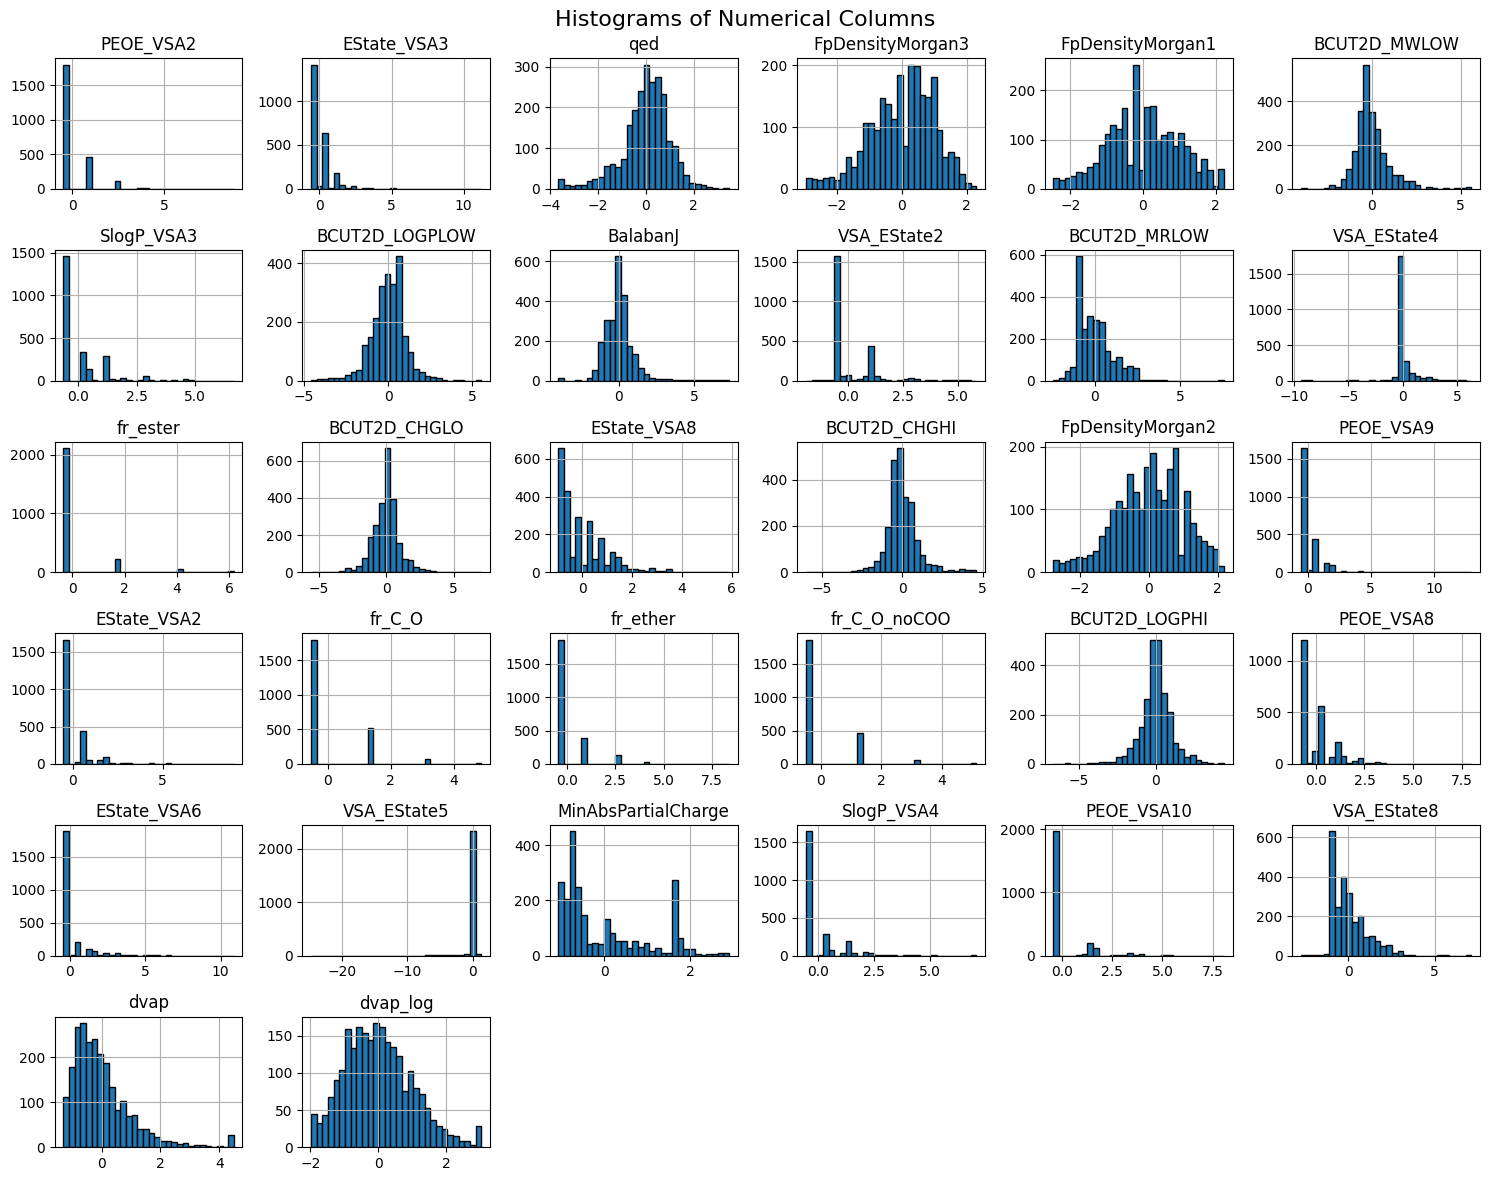

In [21]:
# Select only numerical columns
numeric_cols = final_data_scaled.select_dtypes(include=['number']).columns

# Plot histograms
final_data_scaled[numeric_cols].hist(figsize=(15, 12), bins=30, edgecolor='black')
plt.suptitle("Histograms of Numerical Columns", fontsize=16)
plt.tight_layout()
plt.show()

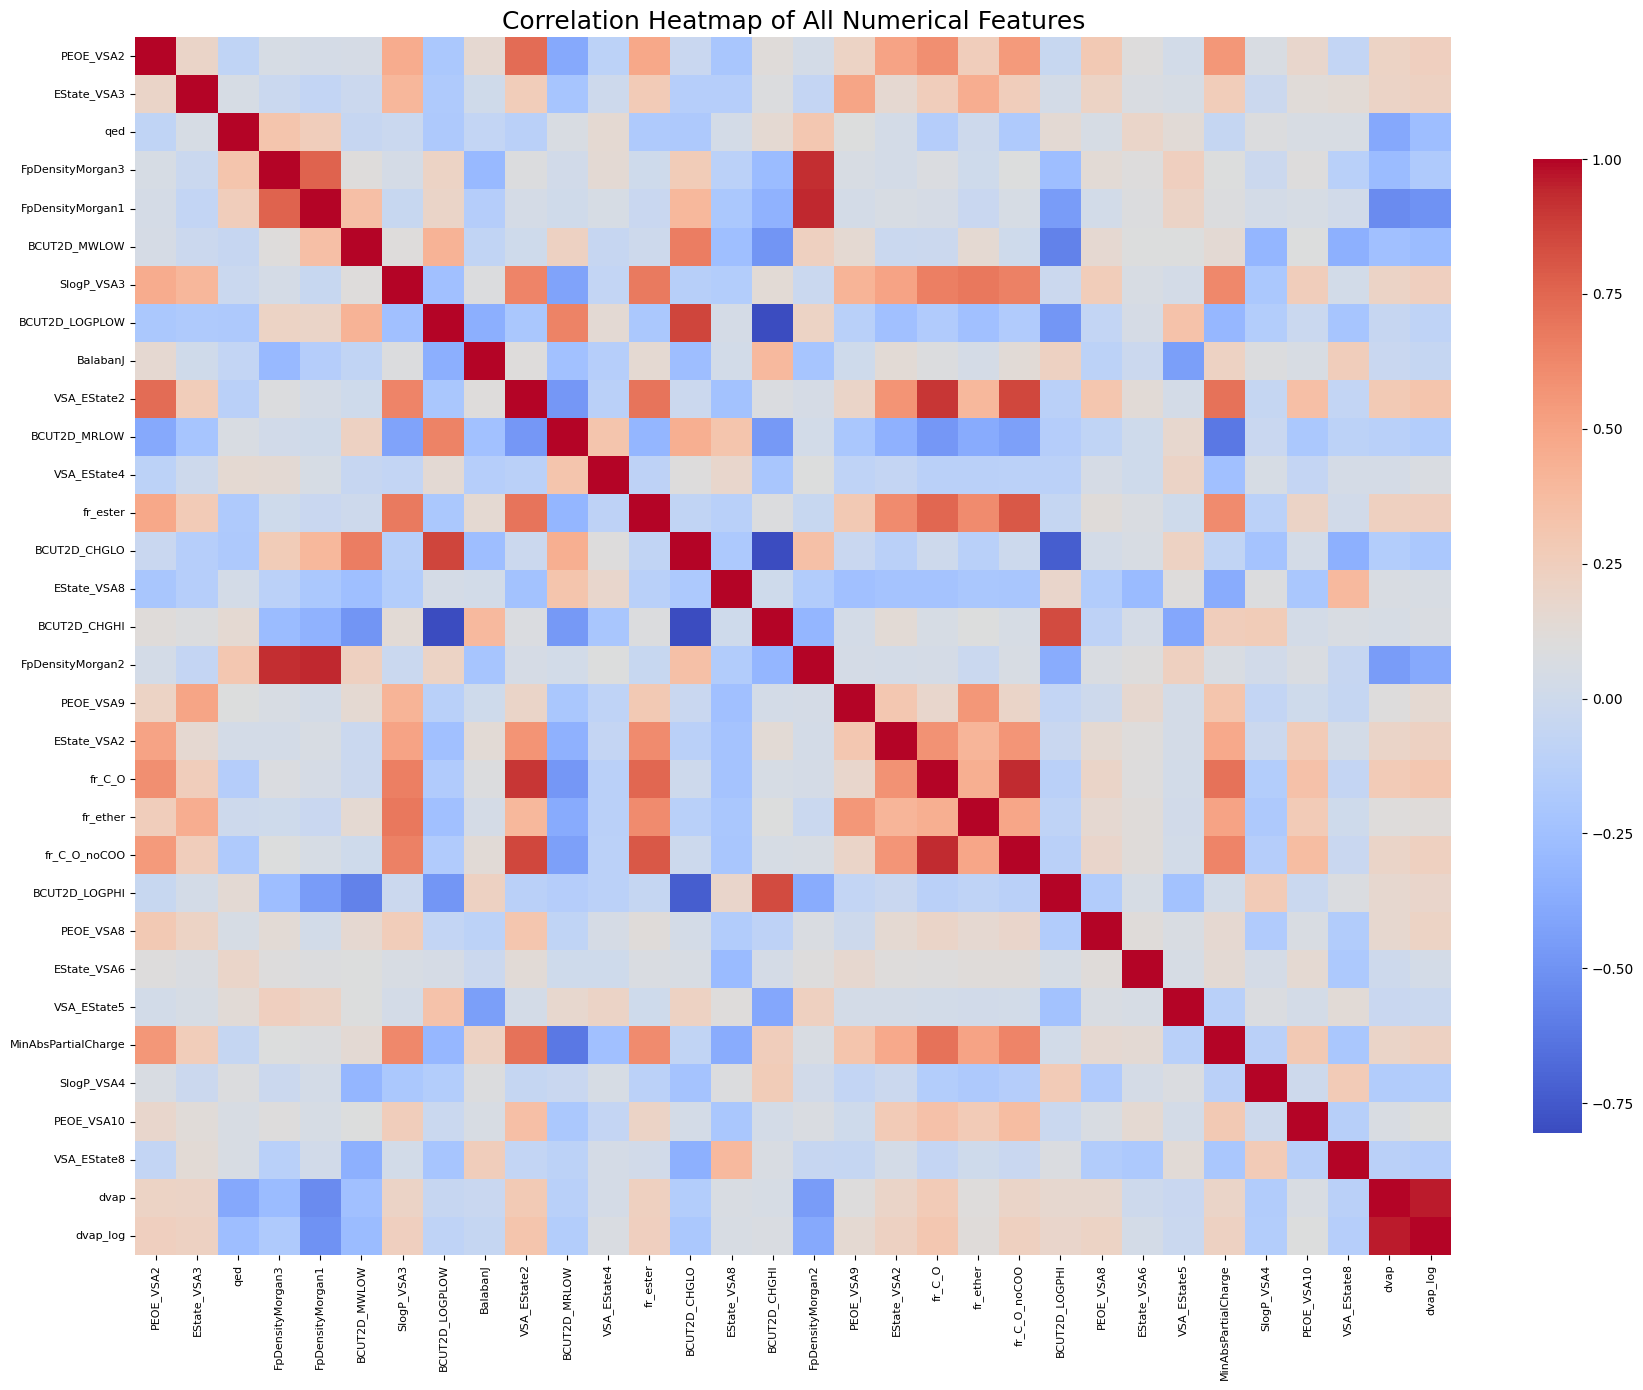

In [22]:


# Compute correlation matrix
corr = final_data[numeric_cols].corr()

# Plot readable full heatmap
plt.figure(figsize=(18, 14))
sns.heatmap(
    corr,
    cmap='coolwarm',
    annot=False,          # Disable text for readability
    square=False,
    cbar_kws={"shrink": 0.8}
)
plt.title("Correlation Heatmap of All Numerical Features", fontsize=18)
plt.xticks(fontsize=8, rotation=90)
plt.yticks(fontsize=8)
plt.tight_layout()
plt.show()


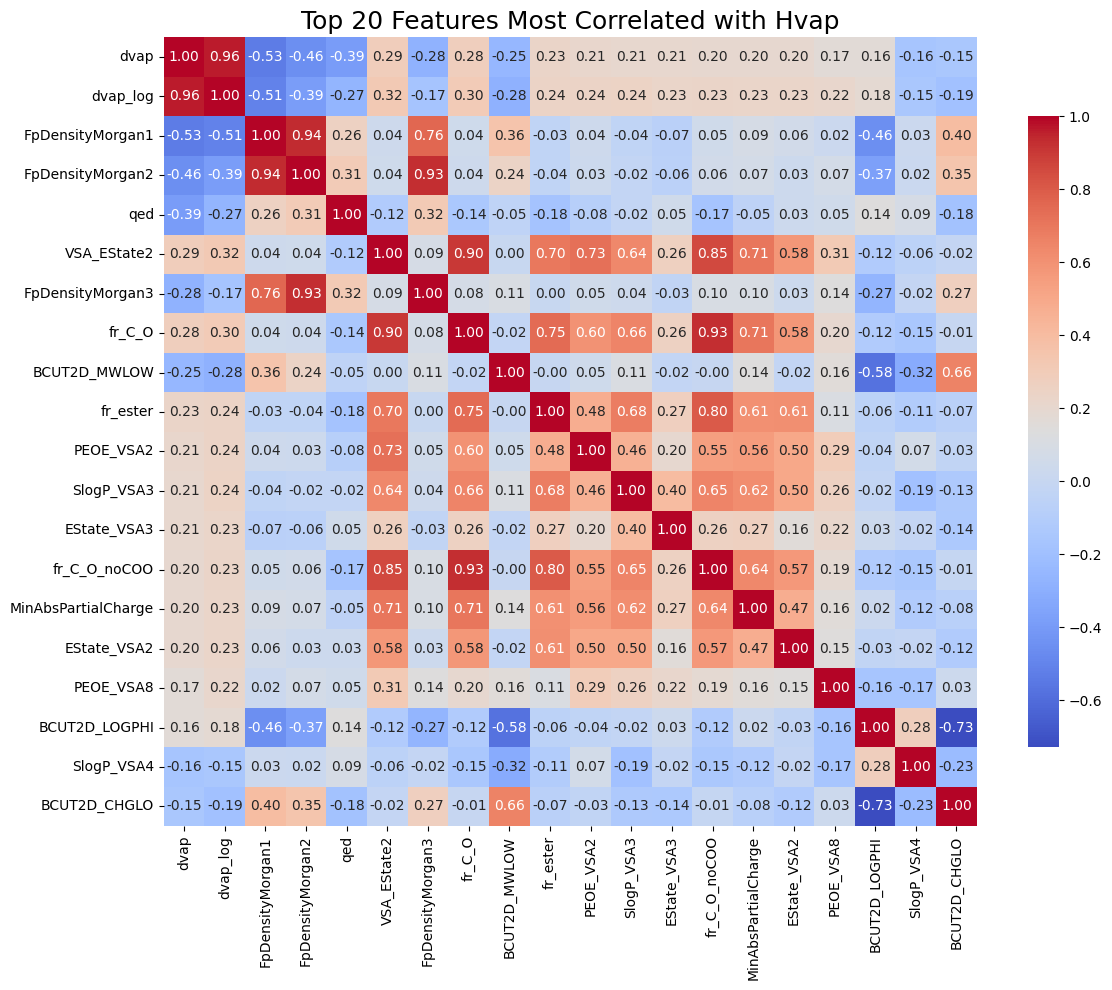

In [23]:


target = "dvap"  # change to your actual column name

# Get correlations with target and sort
corr_with_target = final_data[numeric_cols].corr()[target].abs().sort_values(ascending=False)

# Select top 20 most correlated features
top_features = corr_with_target.head(20).index

plt.figure(figsize=(12, 10))
sns.heatmap(
    final_data[top_features].corr(),
    cmap='coolwarm',
    annot=True,
    fmt=".2f",
    cbar_kws={"shrink": 0.8}
)
plt.title("Top 20 Features Most Correlated with Hvap", fontsize=18)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


## Training  Different Models 

In [24]:
exclude_cols = ['dvap', 'dvap_log']
X_names = [col for col in final_data.columns if col not in exclude_cols]
X = final_data.drop(columns=exclude_cols)
y = final_data['dvap_log'].to_numpy()

In [25]:


# -------------------------------------------
# Define models
# -------------------------------------------
models = [
    linear_model.LinearRegression(),
    RandomForestRegressor(random_state=47),
    ensemble.GradientBoostingRegressor(random_state=47),
    svm.SVR(),
    neural_network.MLPRegressor(random_state=47, max_iter=500),
    Ridge(alpha=1.0, random_state=47),
    Lasso(alpha=0.001, random_state=47),
    ElasticNet(alpha=0.001, l1_ratio=0.5, random_state=47)
]
models += [
    XGBRegressor(random_state=47, n_estimators=500, learning_rate=0.05, max_depth=6),
    LGBMRegressor(random_state=47, n_estimators=500, learning_rate=0.05, max_depth=-1),
    CatBoostRegressor(random_seed=47, verbose=False)
]



🔹 Training LinearRegression...


Fitting LinearRegression: 100%|███████████████████████████████████████| 1/1 [00:00<00:00, 91.59it/s]


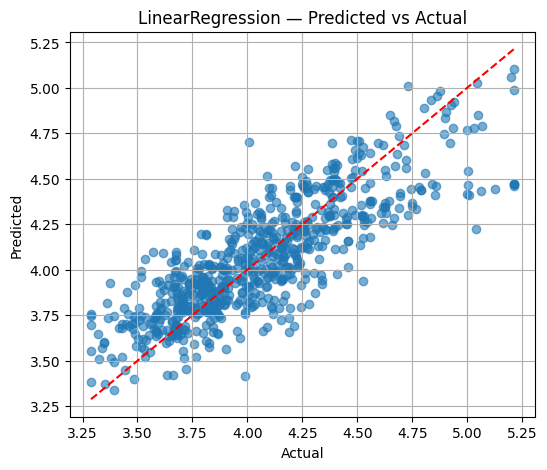

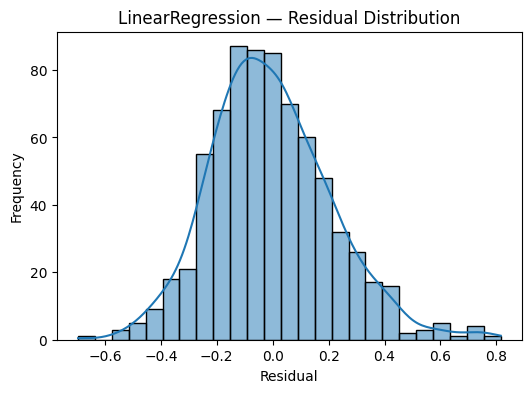

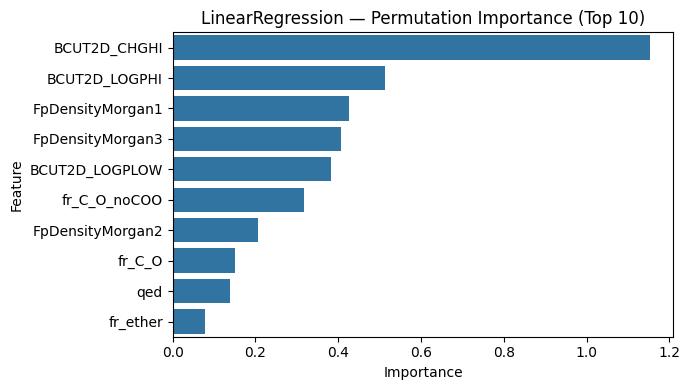


🔹 Training RandomForestRegressor...


Fitting RandomForestRegressor: 100%|██████████████████████████████████| 1/1 [00:04<00:00,  4.93s/it]


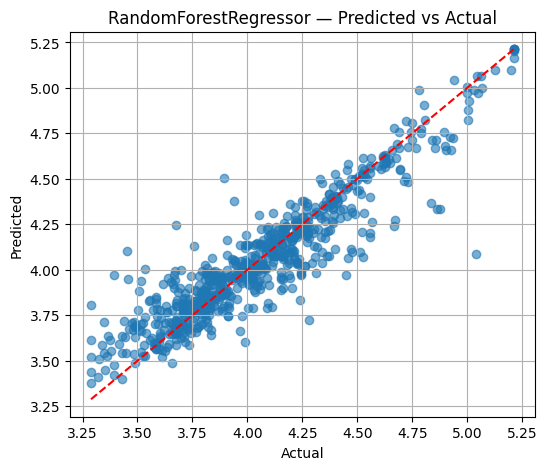

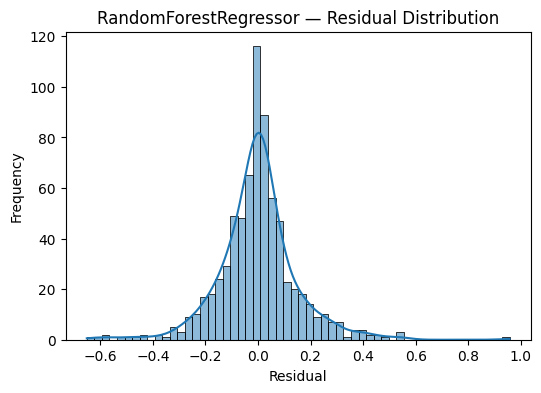

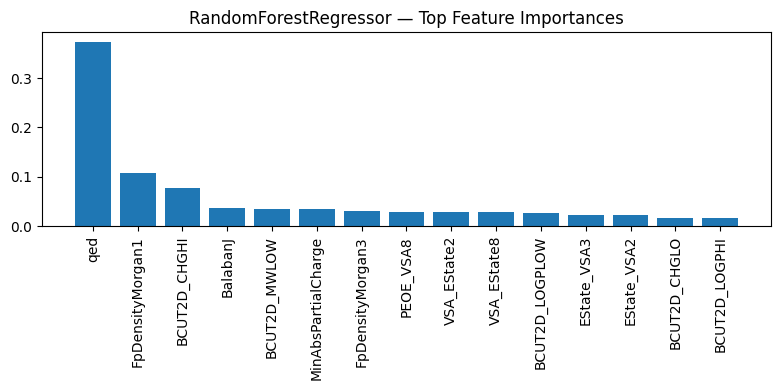

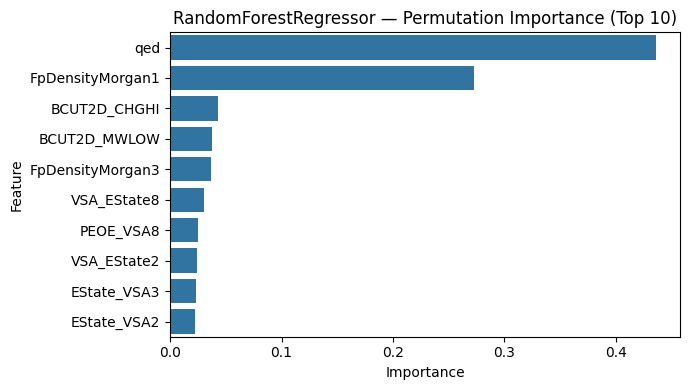


🔹 Training GradientBoostingRegressor...


Fitting GradientBoostingRegressor: 100%|██████████████████████████████| 1/1 [00:02<00:00,  2.06s/it]


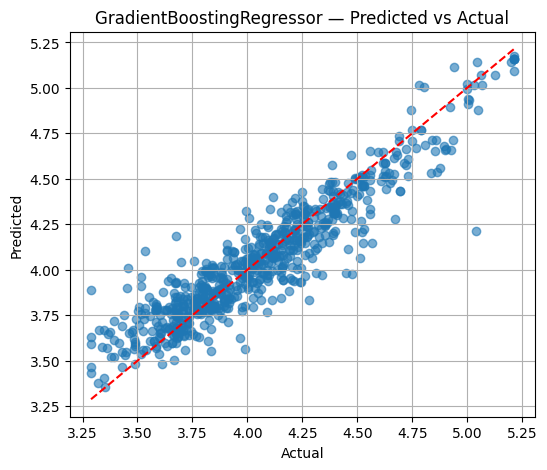

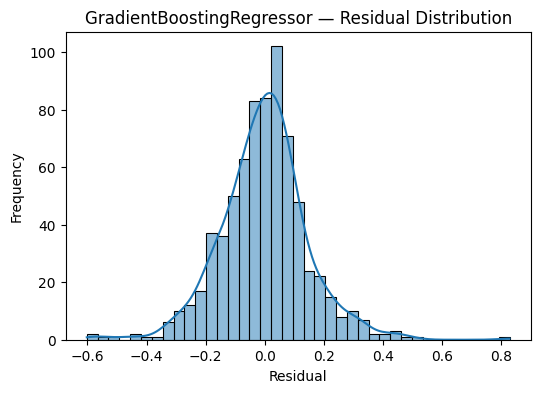

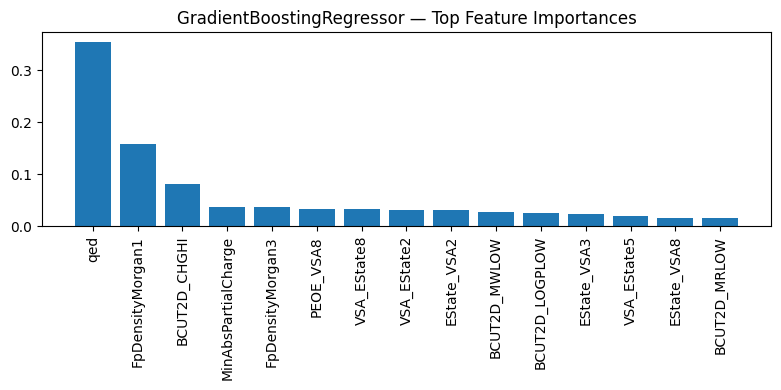

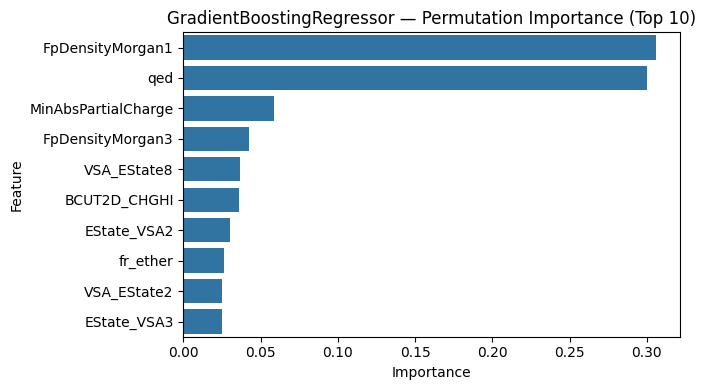


🔹 Training SVR...


Fitting SVR: 100%|████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.61it/s]


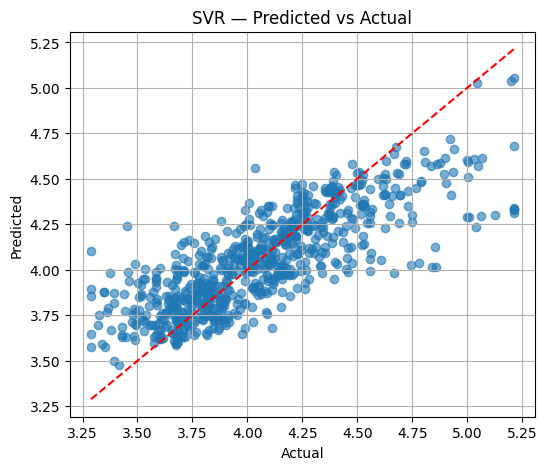

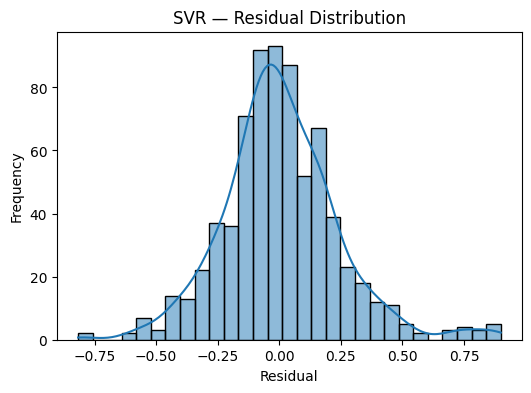

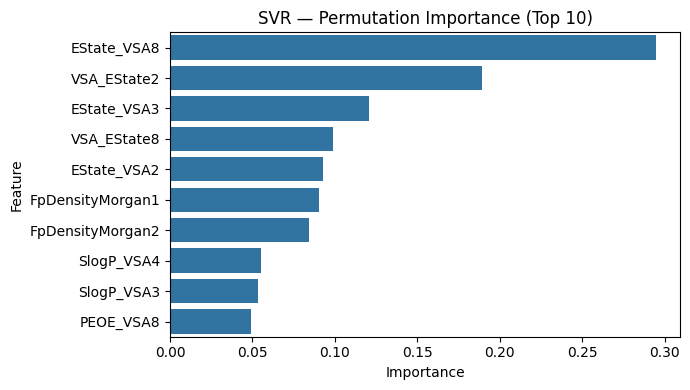


🔹 Training MLPRegressor...


Fitting MLPRegressor: 100%|███████████████████████████████████████████| 1/1 [00:02<00:00,  2.59s/it]


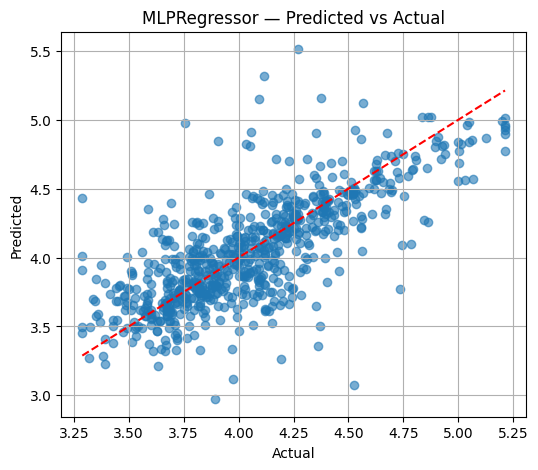

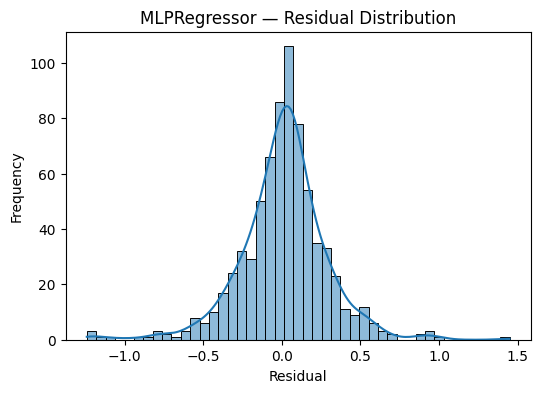

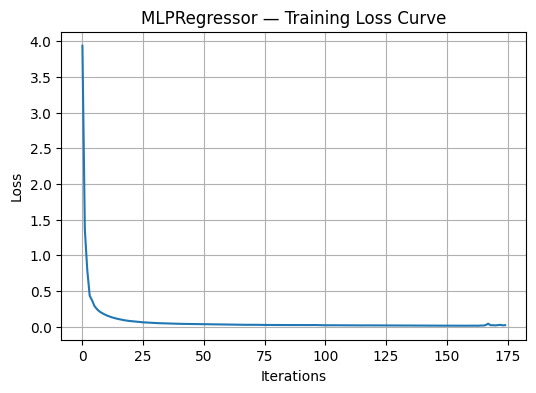

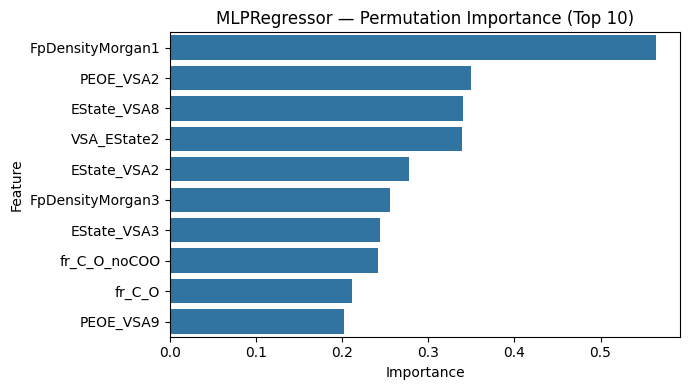


🔹 Training Ridge...


Fitting Ridge: 100%|█████████████████████████████████████████████████| 1/1 [00:00<00:00, 143.84it/s]


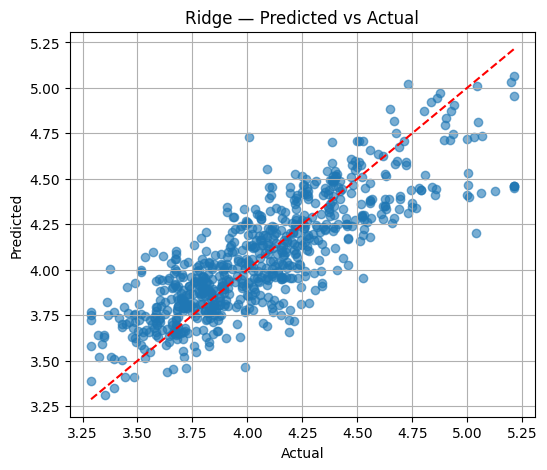

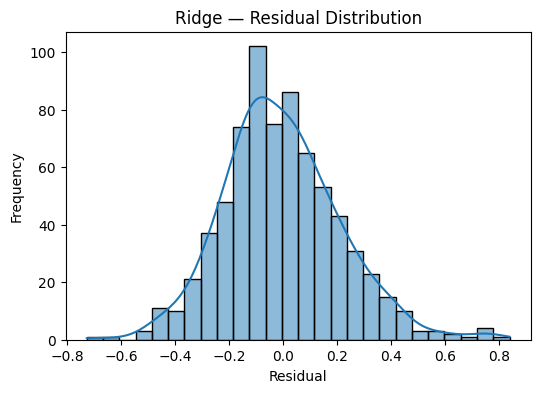

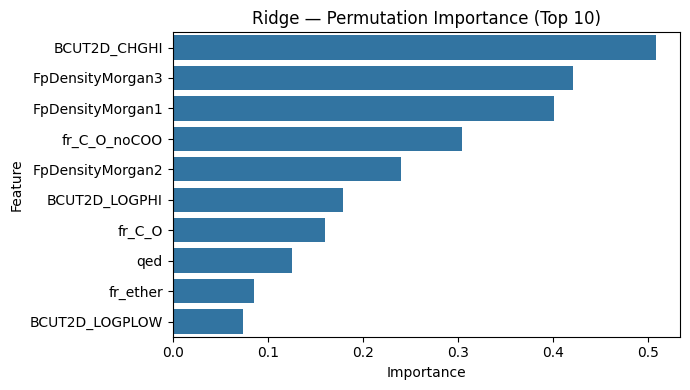


🔹 Training Lasso...


Fitting Lasso: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00, 35.16it/s]


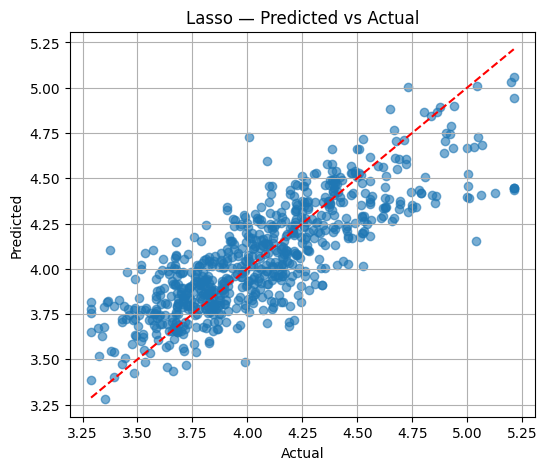

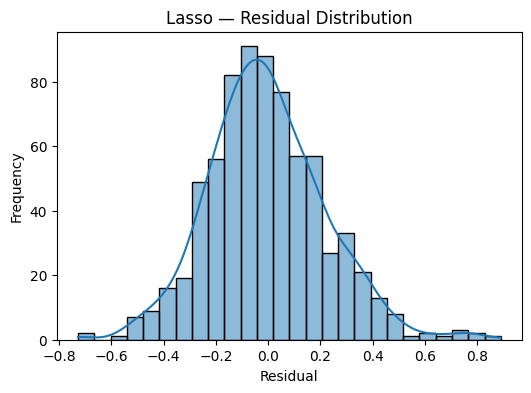

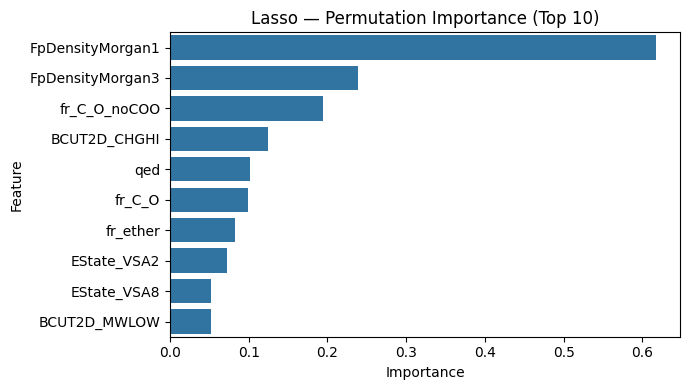


🔹 Training ElasticNet...


Fitting ElasticNet: 100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.77it/s]


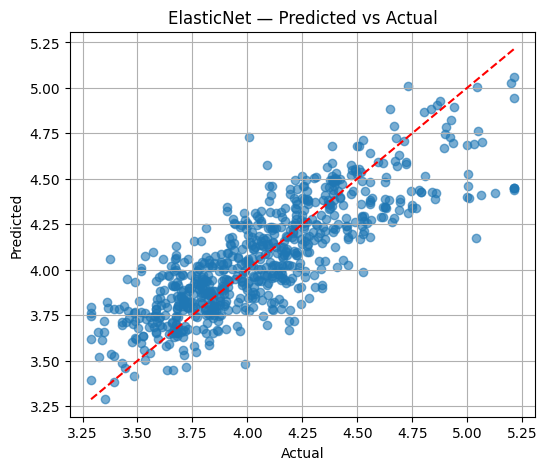

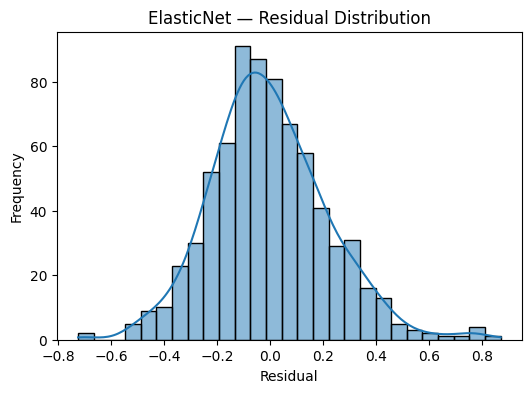

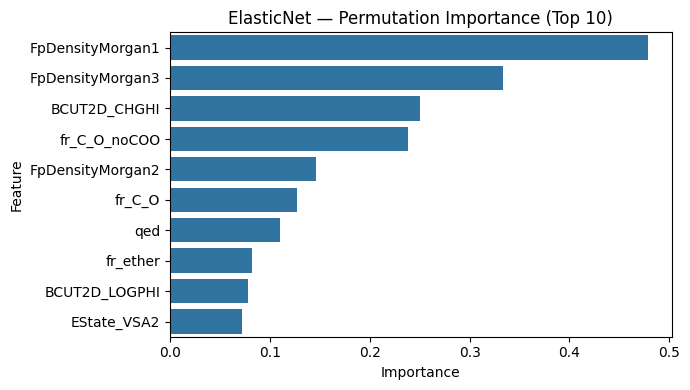


🔹 Training XGBRegressor...


Fitting XGBRegressor: 100%|███████████████████████████████████████████| 1/1 [00:02<00:00,  2.89s/it]


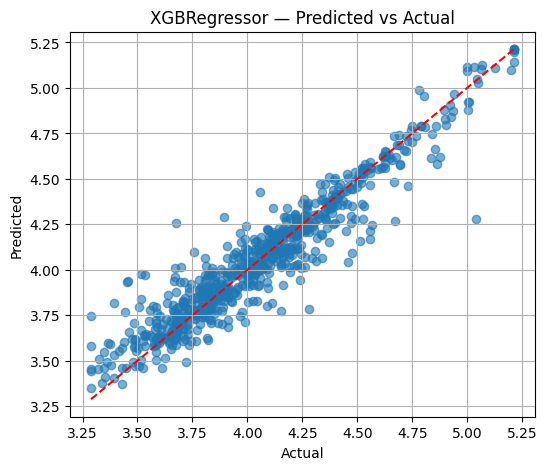

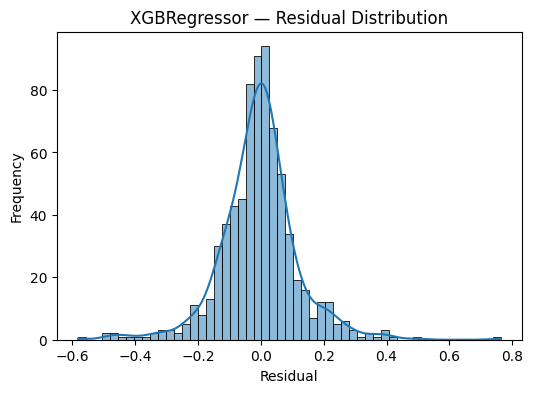

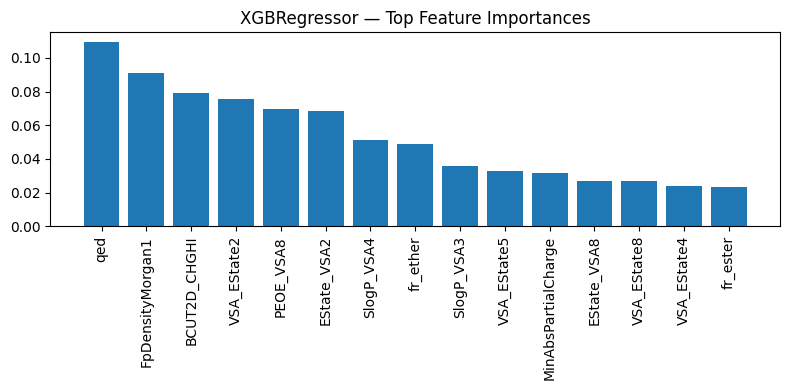

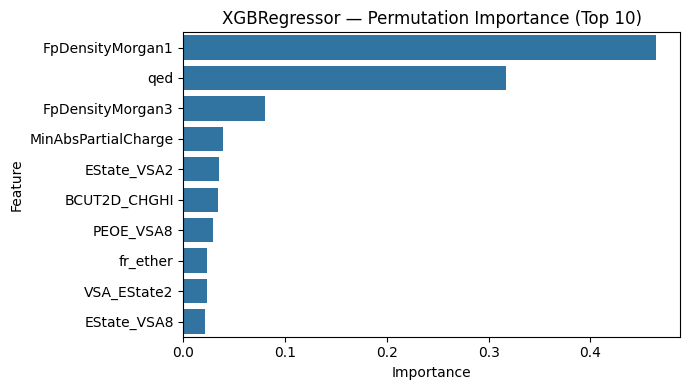


🔹 Training LGBMRegressor...


Fitting LGBMRegressor:   0%|                                                  | 0/1 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002291 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4264
[LightGBM] [Info] Number of data points in the train set: 1687, number of used features: 30
[LightGBM] [Info] Start training from score 4.045959


Fitting LGBMRegressor: 100%|██████████████████████████████████████████| 1/1 [00:06<00:00,  6.20s/it]


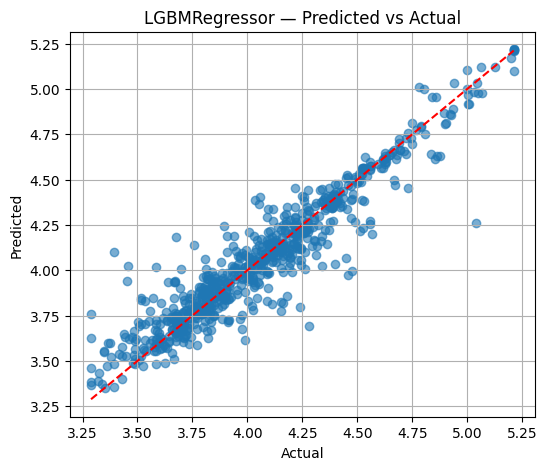

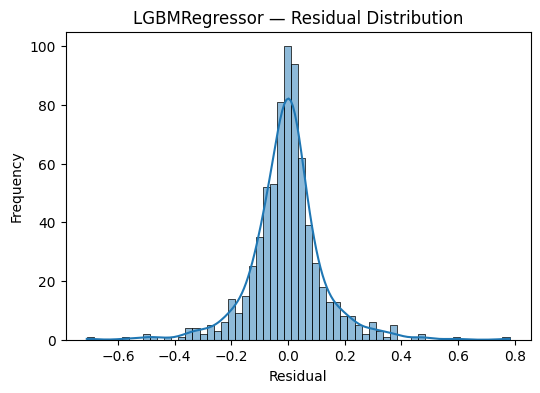

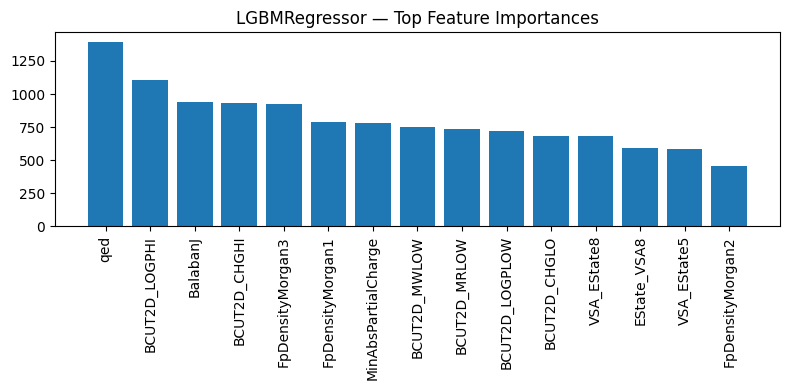

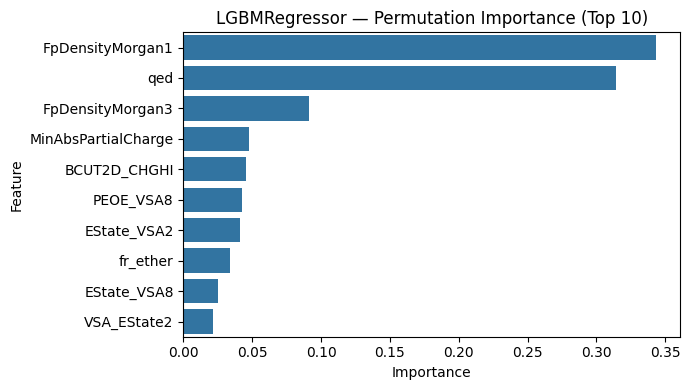


🔹 Training CatBoostRegressor...


Fitting CatBoostRegressor: 100%|██████████████████████████████████████| 1/1 [00:04<00:00,  4.21s/it]


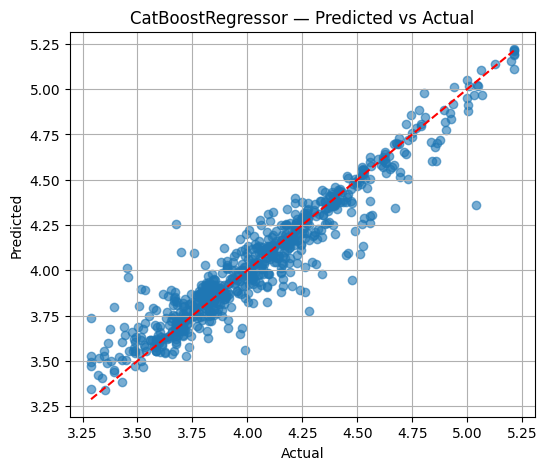

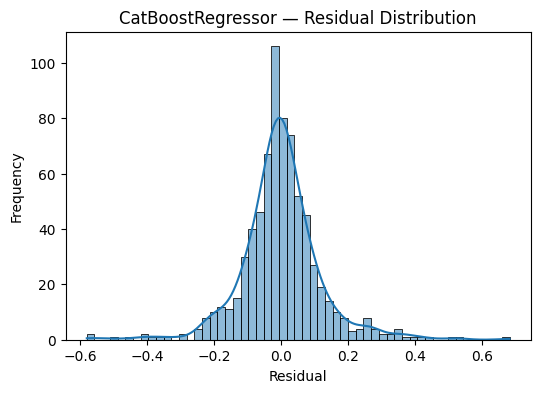

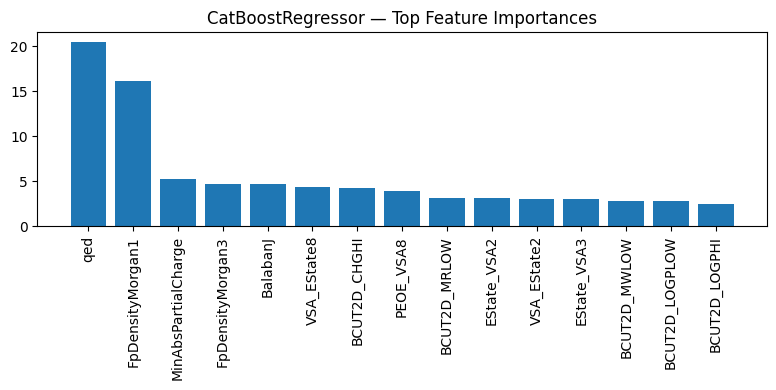

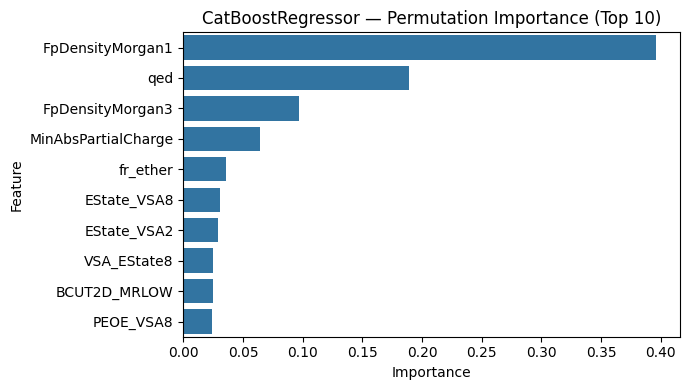

Model  Train_R2  Train_RMSE  Train_MAE   Test_R2  \
0            LinearRegression  0.653478    0.224311   0.173461  0.687673   
1       RandomForestRegressor  0.981631    0.051644   0.036061  0.849935   
2   GradientBoostingRegressor  0.907779    0.115718   0.087641  0.855120   
3                         SVR  0.682721    0.214637   0.154787  0.627667   
4                MLPRegressor  0.686074    0.213500   0.133155  0.484473   
5                       Ridge  0.650396    0.225306   0.173517  0.686349   
6                       Lasso  0.638143    0.229220   0.176513  0.668263   
7                  ElasticNet  0.644595    0.227168   0.174785  0.677725   
8                XGBRegressor  0.997829    0.017756   0.012401  0.896630   
9               LGBMRegressor  0.997252    0.019977   0.014074  0.887384   
10          CatBoostRegressor  0.988466    0.040925   0.030738  0.903410   

    Test_RMSE  Test_MAE  
0    0.216494  0.169474  
1    0.150066  0.101404  
2    0.147450  0.108455  
3    0.236378  0.174552  
4    0.278142  0.195599  
5    0.216952  0.169074  
6    0.223120  0.172540  
7    0.219915  0.170609  
8    0.124549  0.085202  
9    0.130000  0.086397  
10   0.120394  0.080768

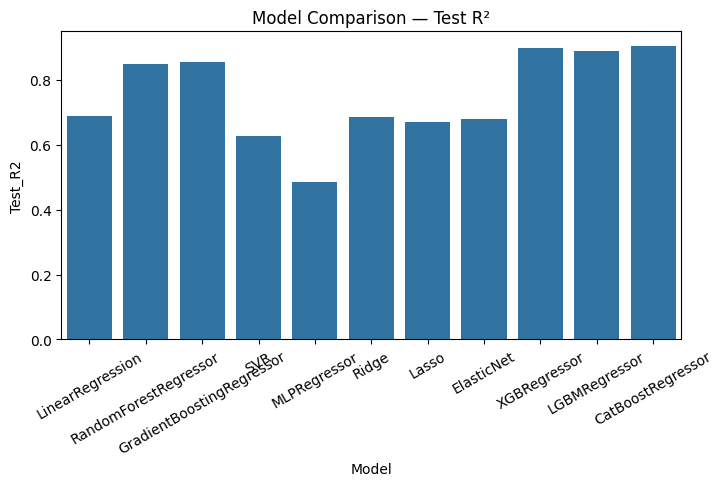

In [26]:

# -------------------------------------------
# Data split
# -------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=42)

# -------------------------------------------
# Helper function for metrics
# -------------------------------------------
def get_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = math.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return {"R2": r2, "RMSE": rmse, "MAE": mae}

# -------------------------------------------
# Training loop
# -------------------------------------------
results = []

for model in models:
    model_name = model.__class__.__name__
    print(f"\n🔹 Training {model_name}...")

    # tqdm progress for fit (especially for iterative models)
    pbar = tqdm(total=1, desc=f"Fitting {model_name}", ncols=100, colour="cyan")
    model.fit(X_train, y_train)
    pbar.update(1)
    pbar.close()

    # Predictions
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    # Metrics
    train_metrics = get_metrics(y_train, y_pred_train)
    test_metrics = get_metrics(y_test, y_pred_test)
    results.append({
        "Model": model_name,
        **{f"Train_{k}": v for k, v in train_metrics.items()},
        **{f"Test_{k}": v for k, v in test_metrics.items()}
    })

    # -------------------------------------------
    # 📈 Plot 1: Predicted vs Actual
    # -------------------------------------------
    plt.figure(figsize=(6, 5))
    plt.scatter(y_test, y_pred_test, alpha=0.6)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.title(f"{model_name} — Predicted vs Actual")
    plt.grid(True)
    plt.show()

    # -------------------------------------------
    # 📉 Plot 2: Residual Plot
    # -------------------------------------------
    residuals = y_test - y_pred_test
    plt.figure(figsize=(6, 4))
    sns.histplot(residuals, kde=True)
    plt.title(f"{model_name} — Residual Distribution")
    plt.xlabel("Residual")
    plt.ylabel("Frequency")
    plt.show()

    # -------------------------------------------
    # 📊 Plot 3: Feature Importance (for tree models)
    # -------------------------------------------
    if hasattr(model, "feature_importances_"):
        importances = model.feature_importances_
        indices = np.argsort(importances)[::-1][:15]  # top 15
        plt.figure(figsize=(8, 4))
        plt.bar(range(len(indices)), importances[indices], align='center')
        plt.xticks(range(len(indices)), np.array(X_train.columns)[indices], rotation=90)
        plt.title(f"{model_name} — Top Feature Importances")
        plt.tight_layout()
        plt.show()

    # -------------------------------------------
    # 📉 Plot 4: Loss Curve (if available)
    # -------------------------------------------
    if hasattr(model, "loss_curve_"):
        plt.figure(figsize=(6, 4))
        plt.plot(model.loss_curve_)
        plt.title(f"{model_name} — Training Loss Curve")
        plt.xlabel("Iterations")
        plt.ylabel("Loss")
        plt.grid(True)
        plt.show()

    # -------------------------------------------
    # 📈 Plot 5: Permutation Importance (for all models)
    # -------------------------------------------
    try:
        perm_importance = permutation_importance(model, X_test, y_test, n_repeats=5, random_state=0)
        perm_df = pd.DataFrame({
            'Feature': X_train.columns,
            'Importance': perm_importance['importances_mean']
        }).sort_values(by='Importance', ascending=False).head(10)

        plt.figure(figsize=(7, 4))
        sns.barplot(x='Importance', y='Feature', data=perm_df)
        plt.title(f"{model_name} — Permutation Importance (Top 10)")
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"⚠️ Skipping permutation importance for {model_name}: {e}")

# -------------------------------------------
# 📊 Summary of All Models
# -------------------------------------------
results_df = pd.DataFrame(results)
display(results_df)

plt.figure(figsize=(8, 4))
sns.barplot(x="Model", y="Test_R2", data=results_df)
plt.title("Model Comparison — Test R²")
plt.xticks(rotation=30)
plt.show()


In [27]:
results_df.to_csv('target_log_dvap_unscaled.csv', index=False)

## FOR DVAP AS TARGET VARIABLE WITHOUT SCALING

In [28]:
y = final_data['dvap'].to_numpy()


🔹 Training LinearRegression...


Fitting LinearRegression: 100%|██████████████████████████████████████| 1/1 [00:00<00:00, 104.95it/s]


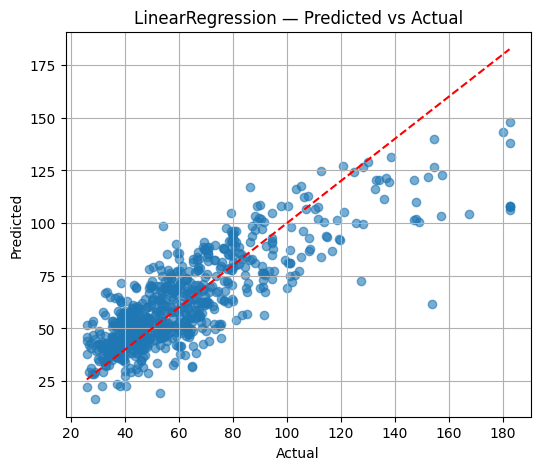

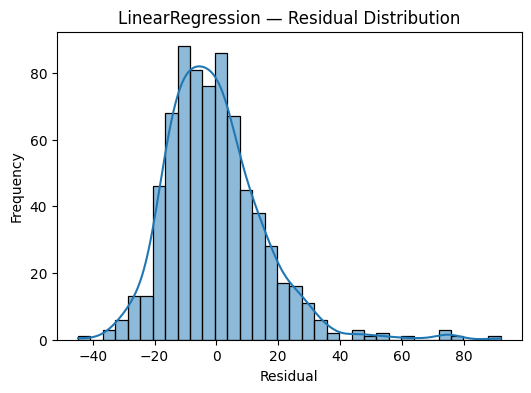

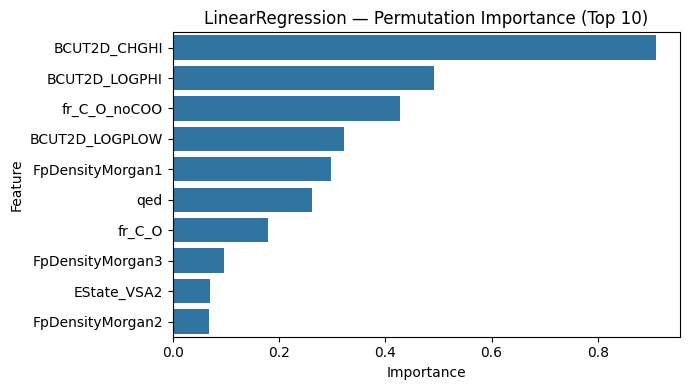


🔹 Training RandomForestRegressor...


Fitting RandomForestRegressor: 100%|██████████████████████████████████| 1/1 [00:04<00:00,  4.89s/it]


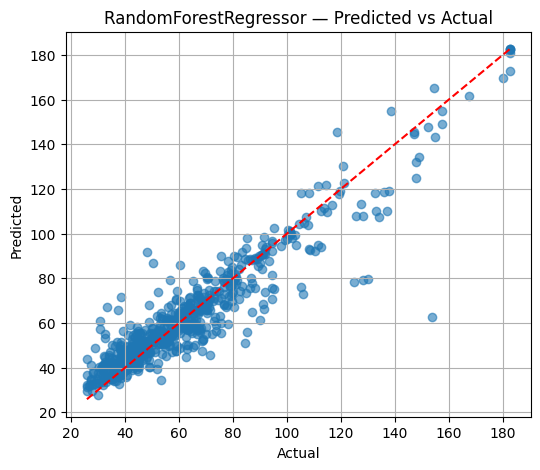

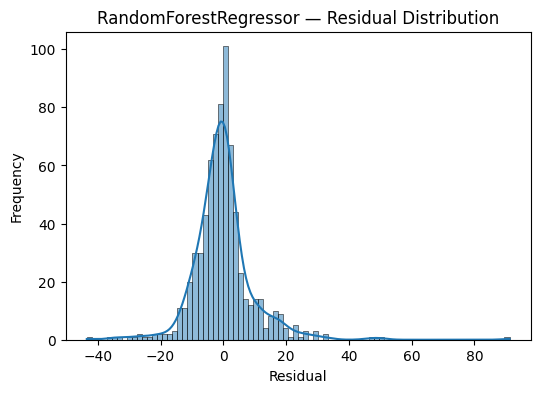

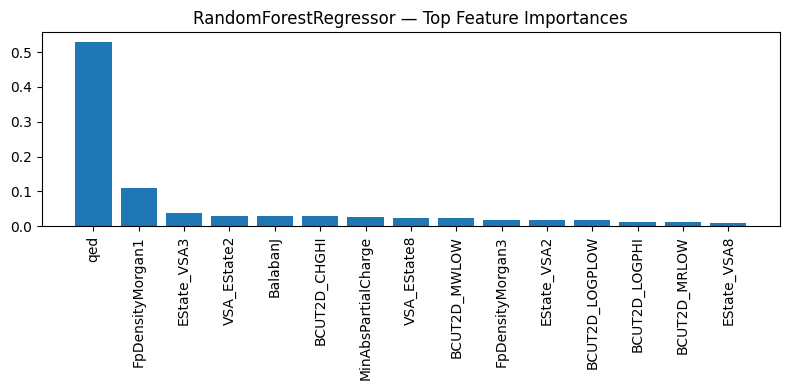

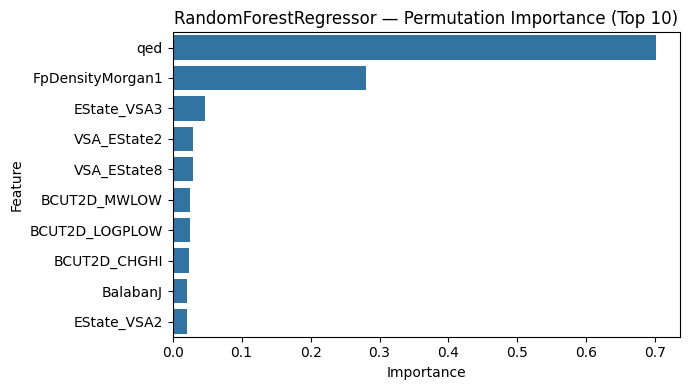


🔹 Training GradientBoostingRegressor...


Fitting GradientBoostingRegressor: 100%|██████████████████████████████| 1/1 [00:01<00:00,  1.69s/it]


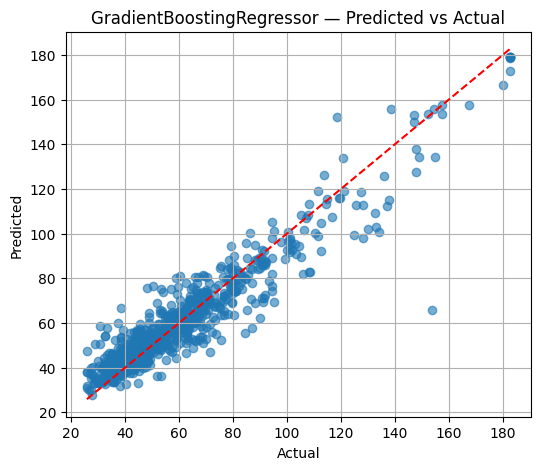

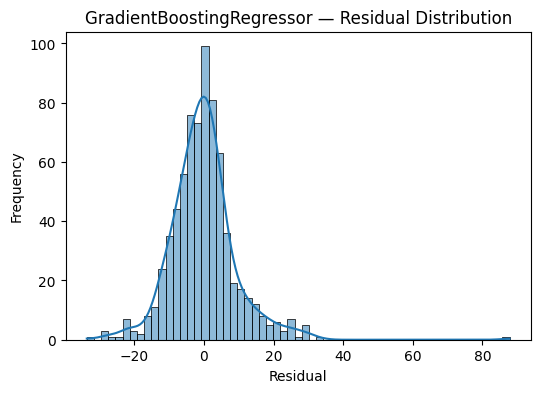

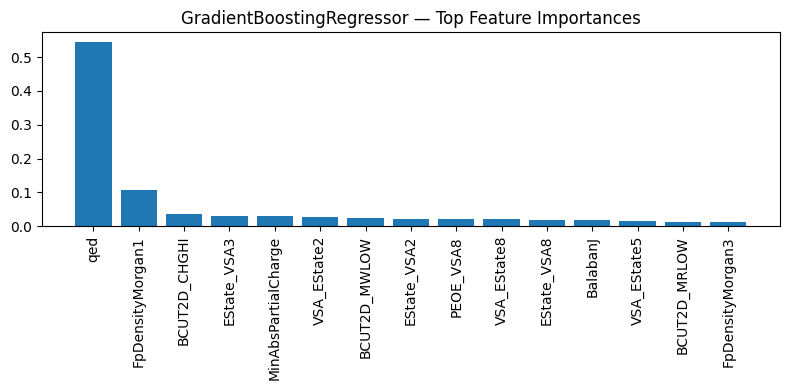

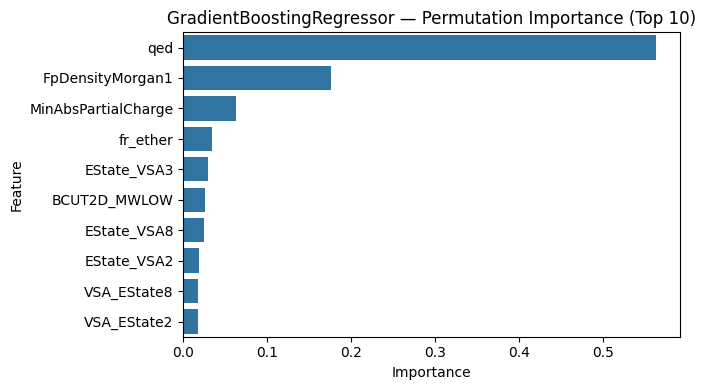


🔹 Training SVR...


Fitting SVR: 100%|████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.54it/s]


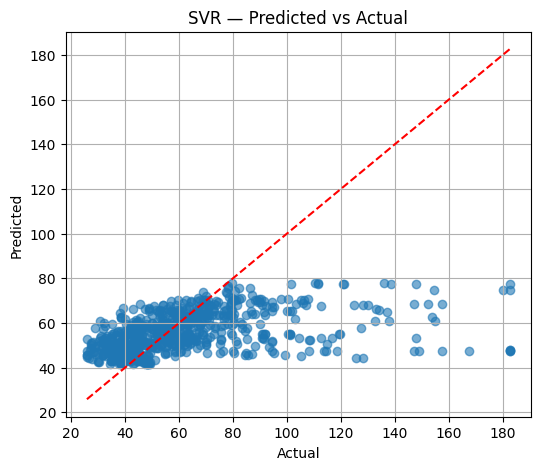

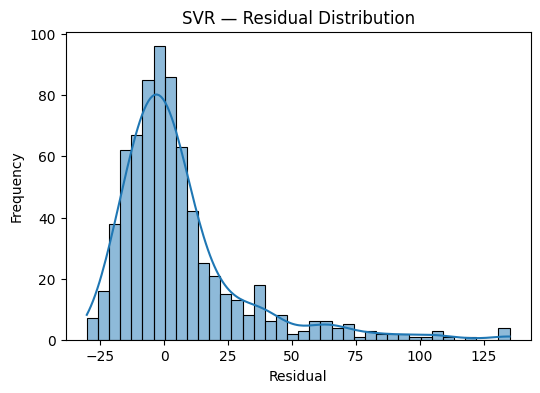

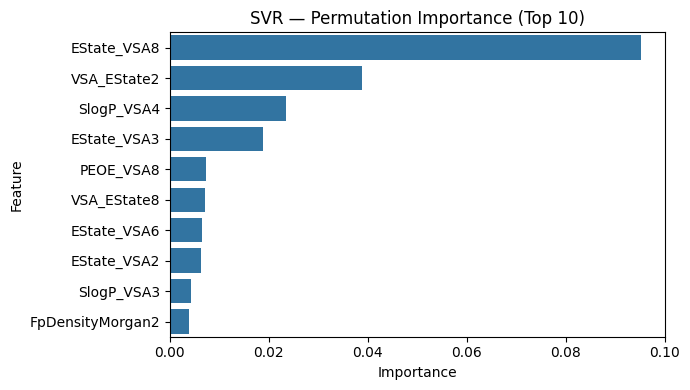


🔹 Training MLPRegressor...


Fitting MLPRegressor:   0%|                                                   | 0/1 [00:00<?, ?it/s]c:\Users\harsh\miniconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.

Fitting MLPRegressor: 100%|███████████████████████████████████████████| 1/1 [00:09<00:00,  9.77s/it]


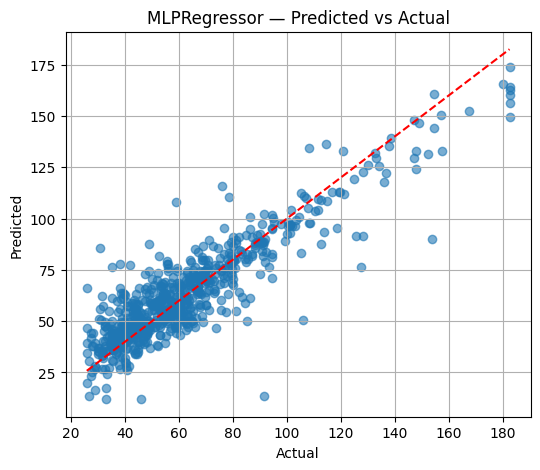

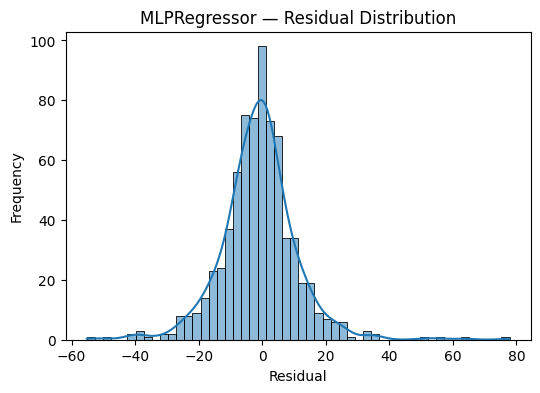

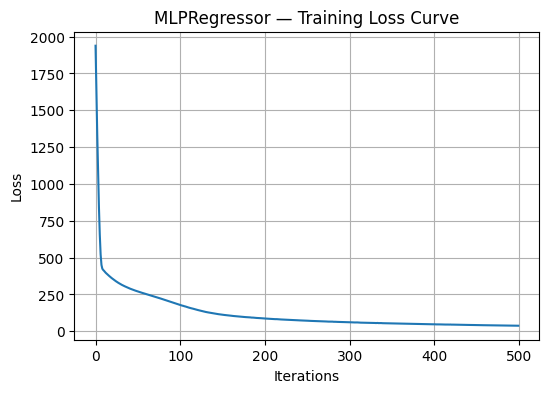

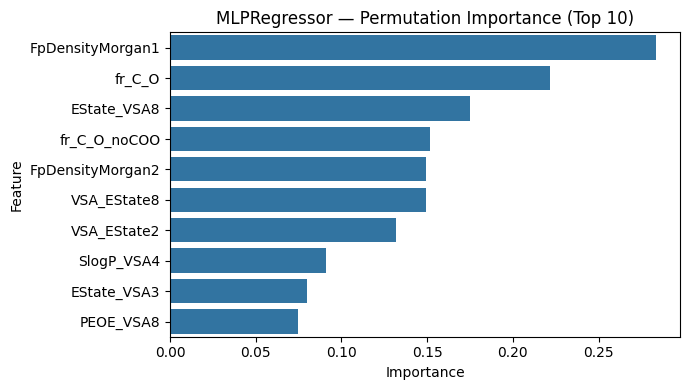


🔹 Training Ridge...


Fitting Ridge: 100%|█████████████████████████████████████████████████| 1/1 [00:00<00:00, 188.66it/s]


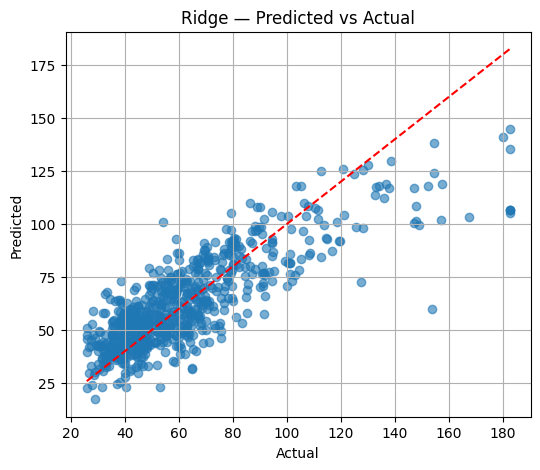

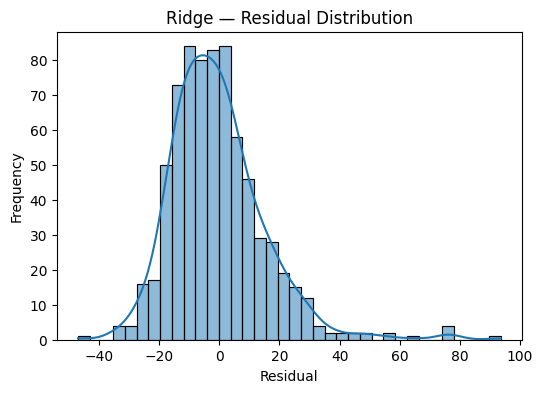

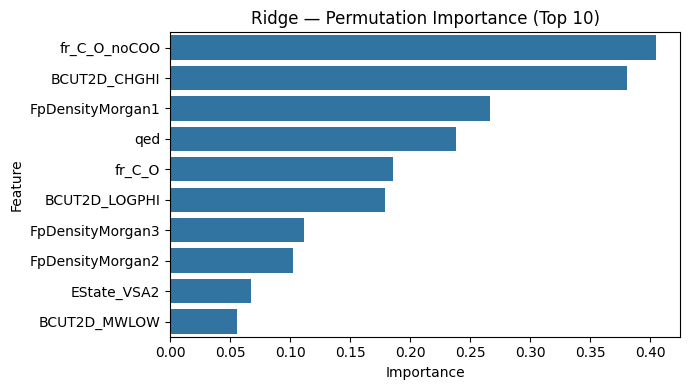


🔹 Training Lasso...


Fitting Lasso: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00, 29.99it/s]


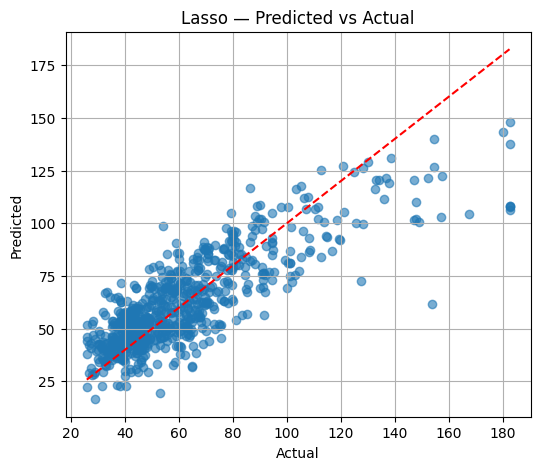

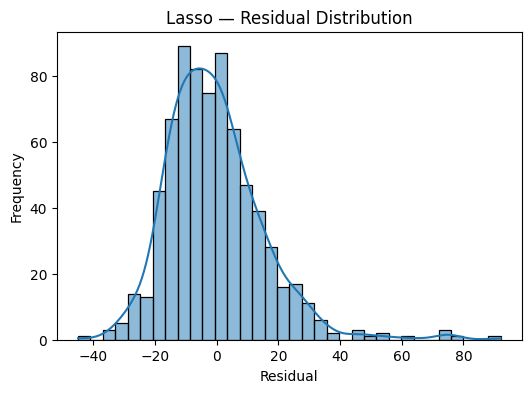

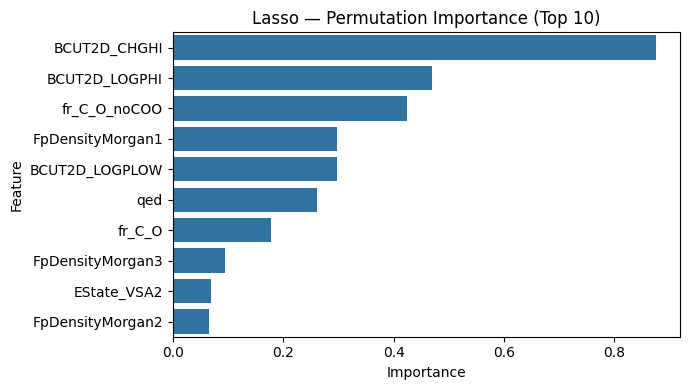


🔹 Training ElasticNet...


Fitting ElasticNet: 100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.74it/s]


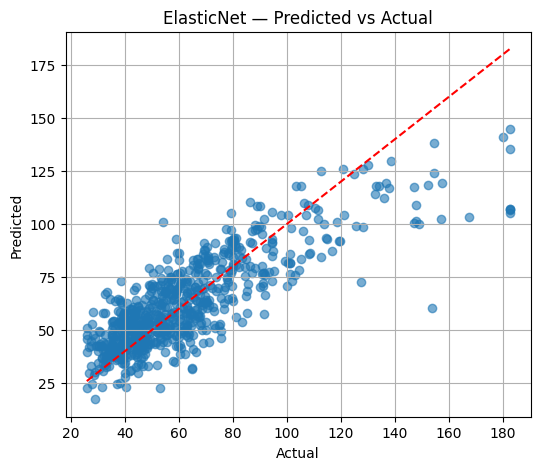

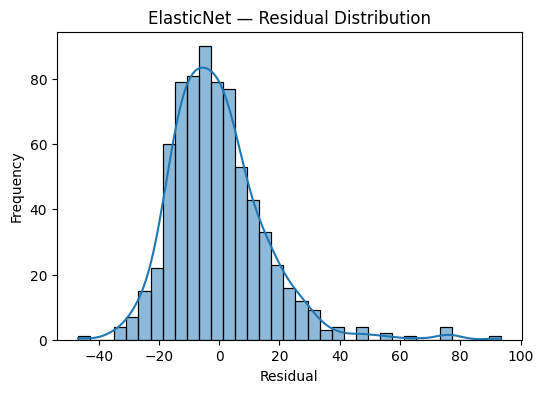

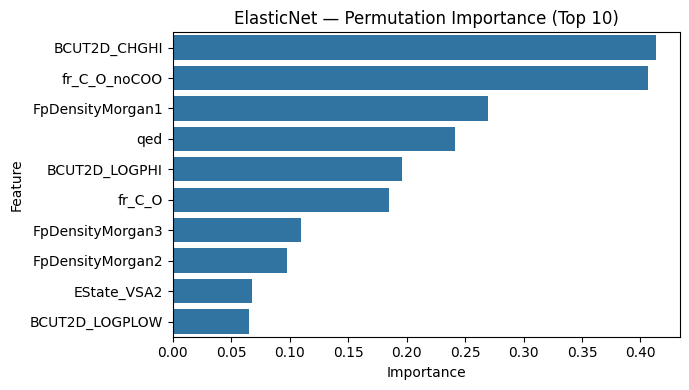


🔹 Training XGBRegressor...


Fitting XGBRegressor: 100%|███████████████████████████████████████████| 1/1 [00:01<00:00,  1.33s/it]


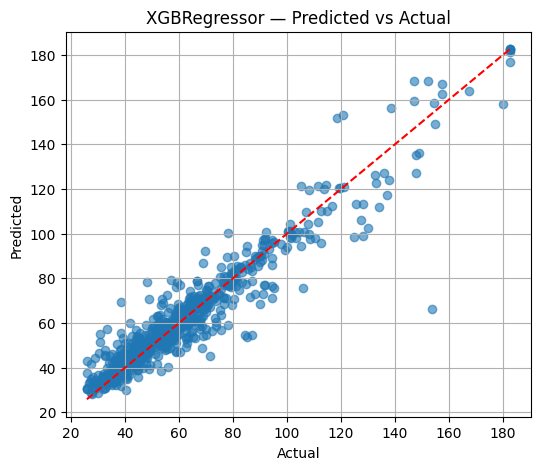

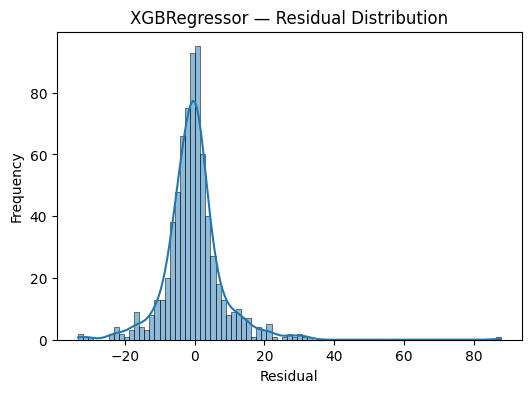

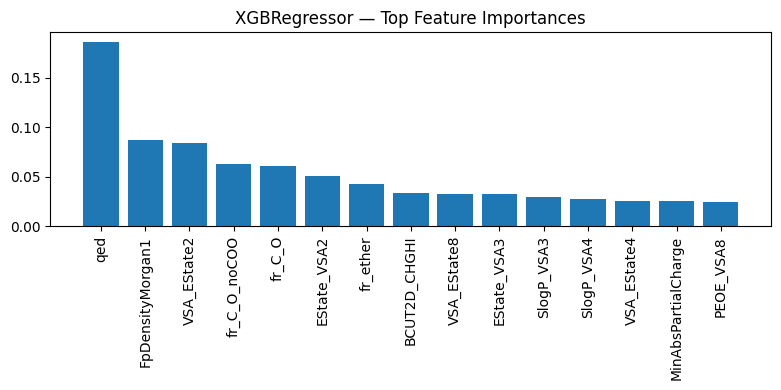

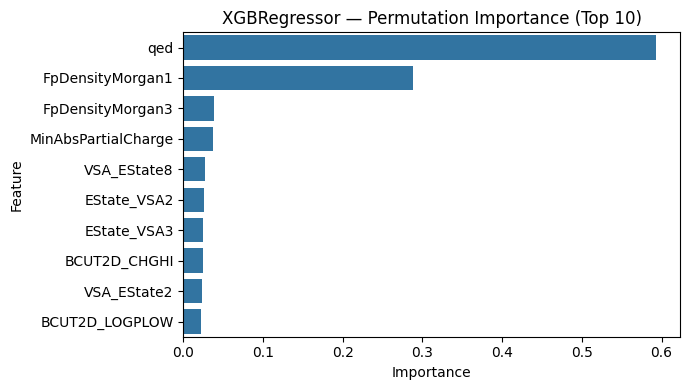


🔹 Training LGBMRegressor...


Fitting LGBMRegressor:   0%|                                                  | 0/1 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000635 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4264
[LightGBM] [Info] Number of data points in the train set: 1687, number of used features: 30
[LightGBM] [Info] Start training from score 60.731768


Fitting LGBMRegressor: 100%|██████████████████████████████████████████| 1/1 [00:00<00:00,  1.45it/s]


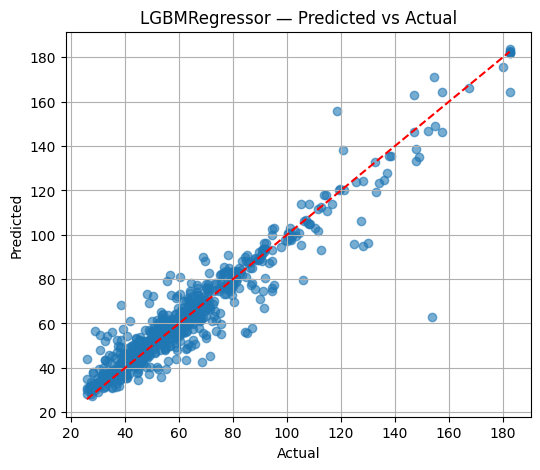

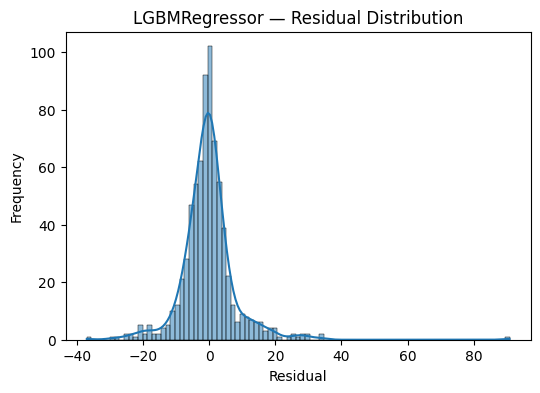

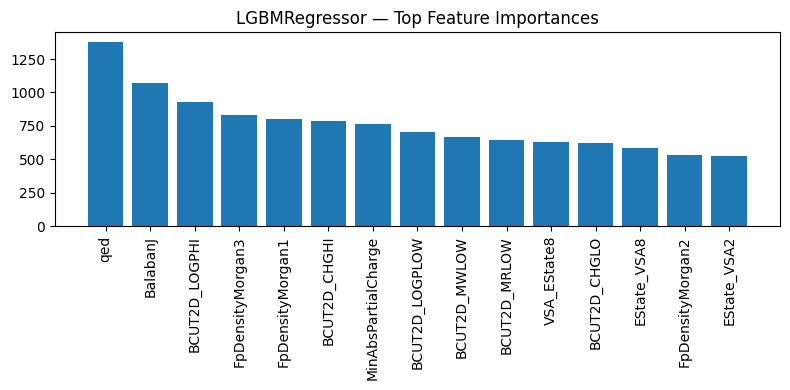

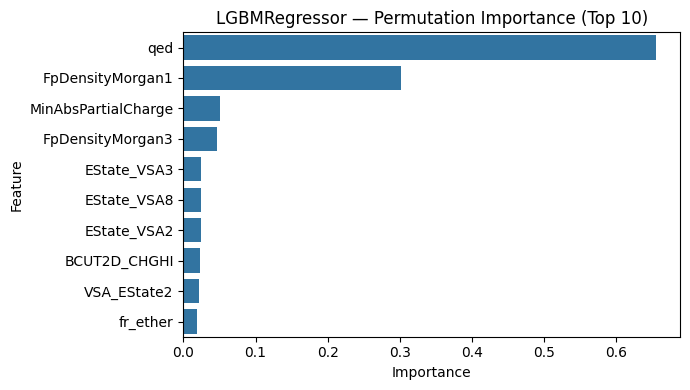


🔹 Training CatBoostRegressor...


Fitting CatBoostRegressor: 100%|██████████████████████████████████████| 1/1 [00:03<00:00,  3.85s/it]


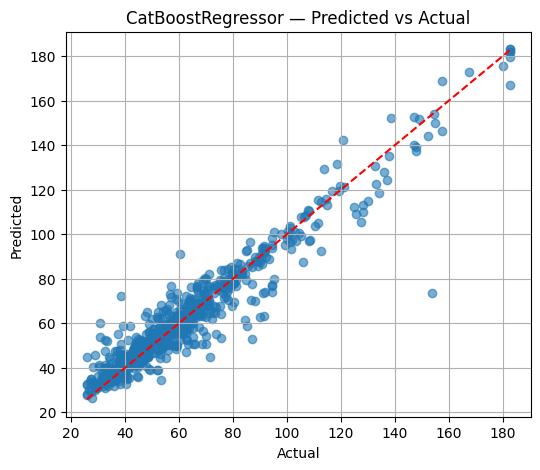

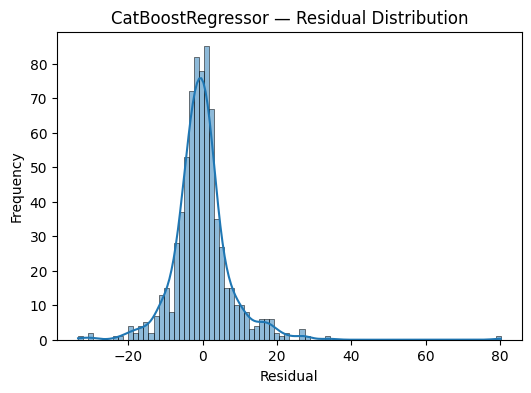

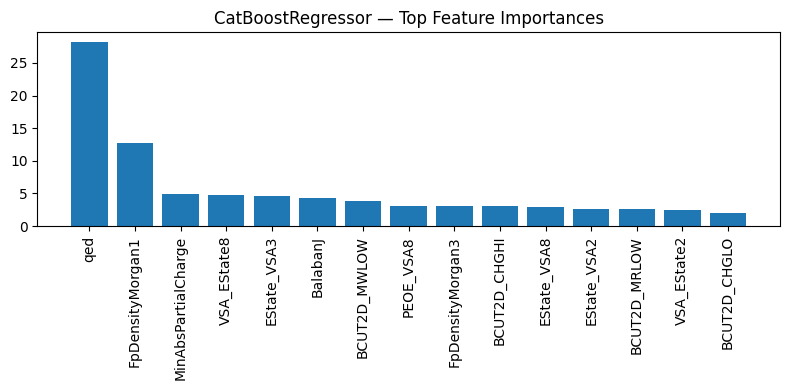

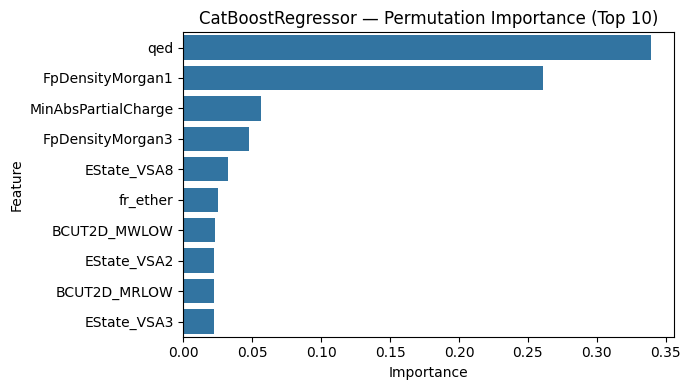

Model  Train_R2  Train_RMSE  Train_MAE   Test_R2  \
0            LinearRegression  0.622082   16.359952  12.003717  0.680580   
1       RandomForestRegressor  0.985342    3.222011   2.133750  0.877392   
2   GradientBoostingRegressor  0.933892    6.842407   5.169575  0.884742   
3                         SVR  0.148515   24.556786  15.323545  0.139647   
4                MLPRegressor  0.892844    8.711456   6.290657  0.811133   
5                       Ridge  0.618955   16.427484  11.933753  0.678239   
6                       Lasso  0.622071   16.360176  11.998981  0.680679   
7                  ElasticNet  0.619454   16.416721  11.936891  0.678820   
8                XGBRegressor  0.998446    1.049165   0.726332  0.906708   
9               LGBMRegressor  0.997391    1.359243   0.912206  0.910157   
10          CatBoostRegressor  0.991714    2.422393   1.838357  0.922166   

    Test_RMSE   Test_MAE  
0   15.767388  11.751832  
1    9.768707   6.178578  
2    9.471406   6.570456  
3   25.877178  15.987370  
4   12.124304   8.436039  
5   15.825045  11.698638  
6   15.764950  11.745331  
7   15.810769  11.697388  
8    8.521200   5.403135  
9    8.362212   5.164301  
10   7.783303   5.026817

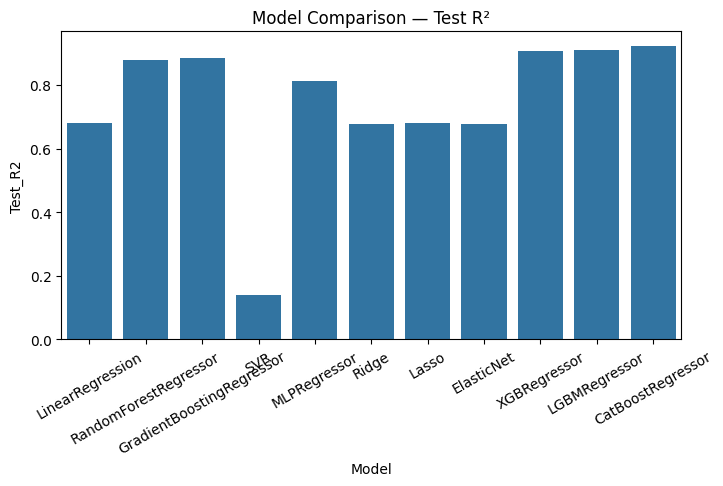

In [29]:
# -------------------------------------------
# Data split
# -------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=42)

# -------------------------------------------
# Helper function for metrics
# -------------------------------------------
def get_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = math.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return {"R2": r2, "RMSE": rmse, "MAE": mae}

# -------------------------------------------
# Training loop
# -------------------------------------------
results = []

for model in models:
    model_name = model.__class__.__name__
    print(f"\n🔹 Training {model_name}...")

    # tqdm progress for fit (especially for iterative models)
    pbar = tqdm(total=1, desc=f"Fitting {model_name}", ncols=100, colour="cyan")
    model.fit(X_train, y_train)
    pbar.update(1)
    pbar.close()

    # Predictions
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    # Metrics
    train_metrics = get_metrics(y_train, y_pred_train)
    test_metrics = get_metrics(y_test, y_pred_test)
    results.append({
        "Model": model_name,
        **{f"Train_{k}": v for k, v in train_metrics.items()},
        **{f"Test_{k}": v for k, v in test_metrics.items()}
    })

    # -------------------------------------------
    # 📈 Plot 1: Predicted vs Actual
    # -------------------------------------------
    plt.figure(figsize=(6, 5))
    plt.scatter(y_test, y_pred_test, alpha=0.6)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.title(f"{model_name} — Predicted vs Actual")
    plt.grid(True)
    plt.show()

    # -------------------------------------------
    # 📉 Plot 2: Residual Plot
    # -------------------------------------------
    residuals = y_test - y_pred_test
    plt.figure(figsize=(6, 4))
    sns.histplot(residuals, kde=True)
    plt.title(f"{model_name} — Residual Distribution")
    plt.xlabel("Residual")
    plt.ylabel("Frequency")
    plt.show()

    # -------------------------------------------
    # 📊 Plot 3: Feature Importance (for tree models)
    # -------------------------------------------
    if hasattr(model, "feature_importances_"):
        importances = model.feature_importances_
        indices = np.argsort(importances)[::-1][:15]  # top 15
        plt.figure(figsize=(8, 4))
        plt.bar(range(len(indices)), importances[indices], align='center')
        plt.xticks(range(len(indices)), np.array(X_train.columns)[indices], rotation=90)
        plt.title(f"{model_name} — Top Feature Importances")
        plt.tight_layout()
        plt.show()

    # -------------------------------------------
    # 📉 Plot 4: Loss Curve (if available)
    # -------------------------------------------
    if hasattr(model, "loss_curve_"):
        plt.figure(figsize=(6, 4))
        plt.plot(model.loss_curve_)
        plt.title(f"{model_name} — Training Loss Curve")
        plt.xlabel("Iterations")
        plt.ylabel("Loss")
        plt.grid(True)
        plt.show()

    # -------------------------------------------
    # 📈 Plot 5: Permutation Importance (for all models)
    # -------------------------------------------
    try:
        perm_importance = permutation_importance(model, X_test, y_test, n_repeats=5, random_state=0)
        perm_df = pd.DataFrame({
            'Feature': X_train.columns,
            'Importance': perm_importance['importances_mean']
        }).sort_values(by='Importance', ascending=False).head(10)

        plt.figure(figsize=(7, 4))
        sns.barplot(x='Importance', y='Feature', data=perm_df)
        plt.title(f"{model_name} — Permutation Importance (Top 10)")
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"⚠️ Skipping permutation importance for {model_name}: {e}")

# -------------------------------------------
# 📊 Summary of All Models
# -------------------------------------------
results_df = pd.DataFrame(results)
display(results_df)

plt.figure(figsize=(8, 4))
sns.barplot(x="Model", y="Test_R2", data=results_df)
plt.title("Model Comparison — Test R²")
plt.xticks(rotation=30)
plt.show()


In [30]:
results_df.to_csv('target_dvap_unscaled.csv', index=False)

## MODEL WITH TARGET AS LOG_DVAP AND SCALED

In [31]:
exclude_cols = ['dvap', 'dvap_log']
X_names = [col for col in final_data_scaled.columns if col not in exclude_cols]
X = final_data_scaled.drop(columns=exclude_cols)
y = final_data_scaled['dvap_log'].to_numpy()


🔹 Training LinearRegression...


Fitting LinearRegression: 100%|██████████████████████████████████████| 1/1 [00:00<00:00, 111.83it/s]


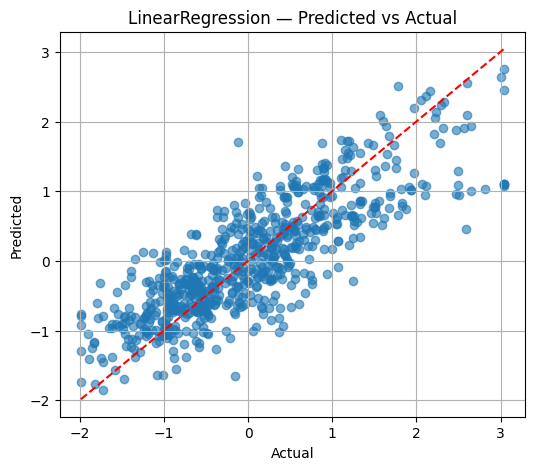

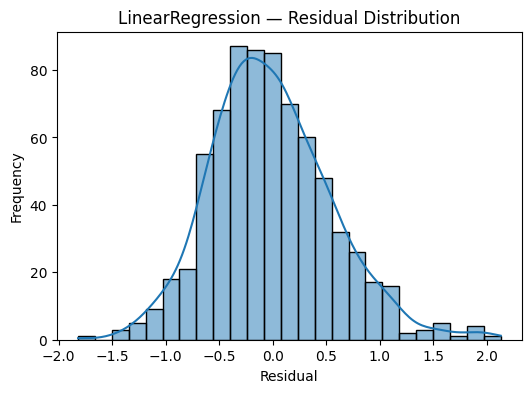

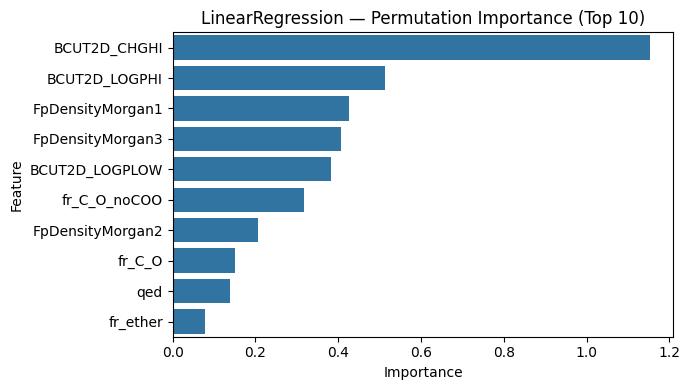


🔹 Training RandomForestRegressor...


Fitting RandomForestRegressor: 100%|██████████████████████████████████| 1/1 [00:04<00:00,  4.50s/it]


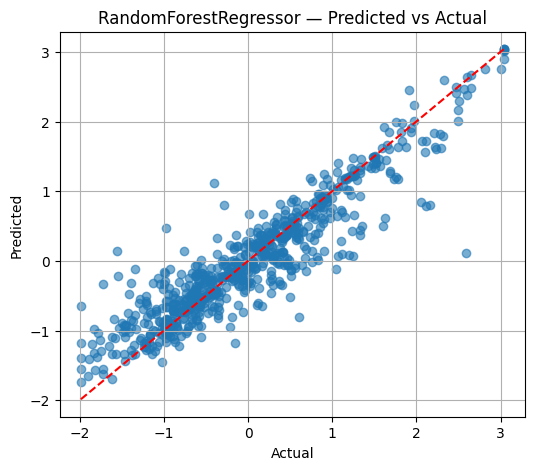

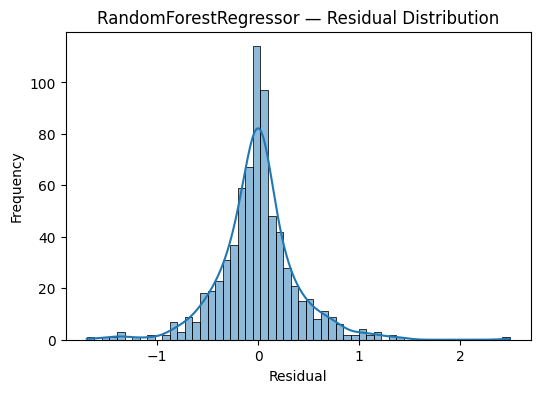

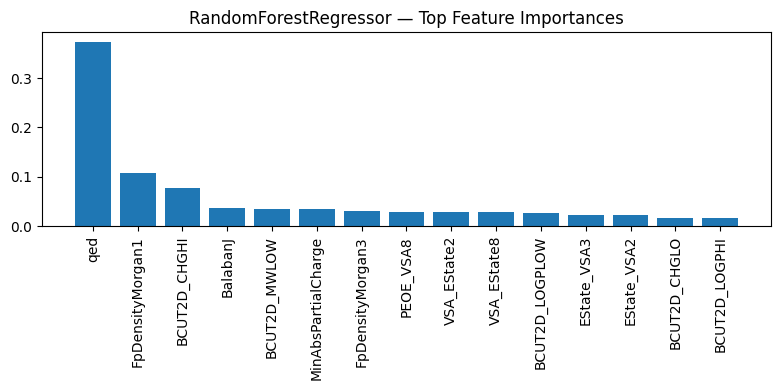

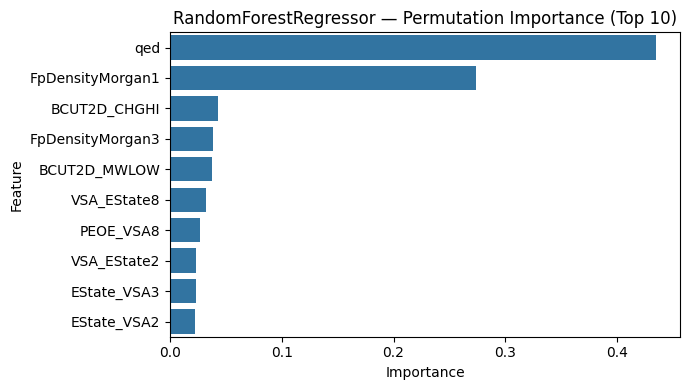


🔹 Training GradientBoostingRegressor...


Fitting GradientBoostingRegressor: 100%|██████████████████████████████| 1/1 [00:01<00:00,  1.70s/it]


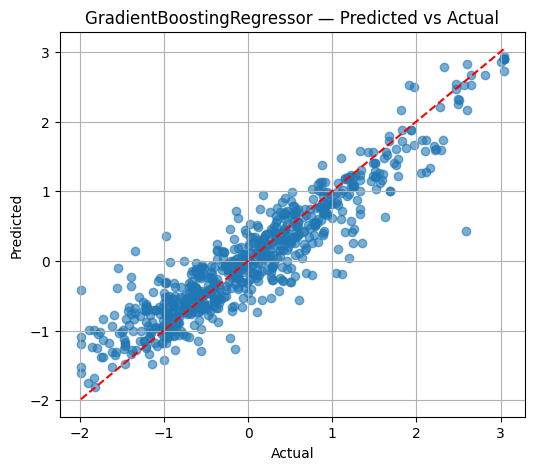

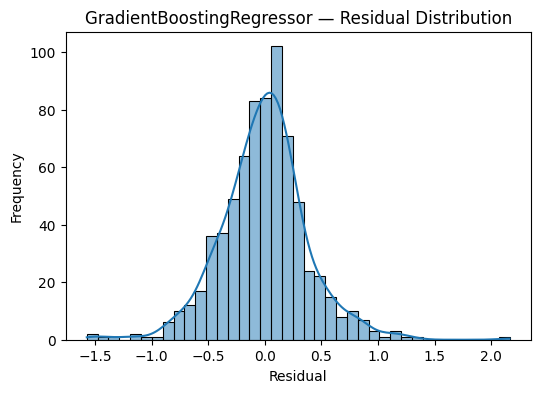

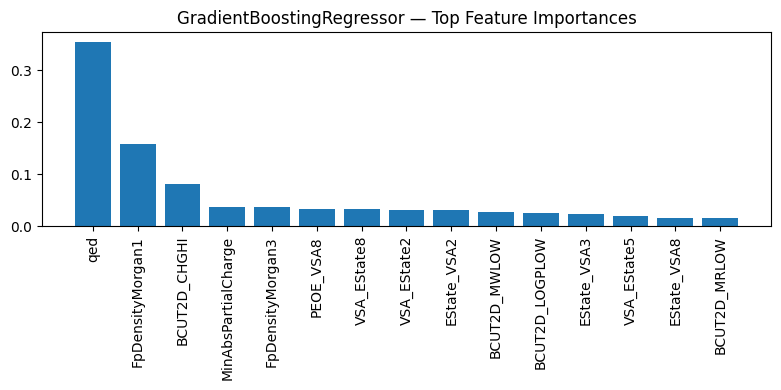

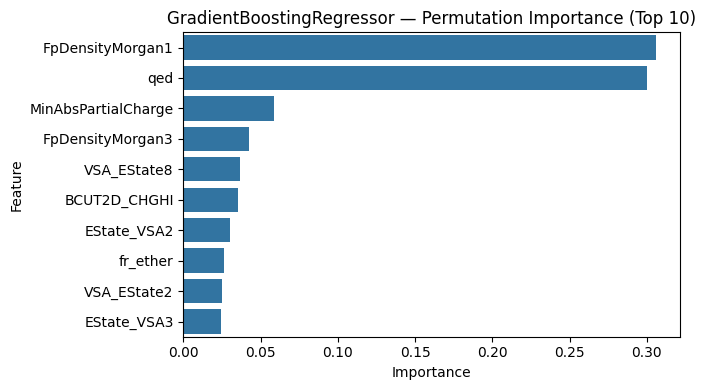


🔹 Training SVR...


Fitting SVR: 100%|████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.33it/s]


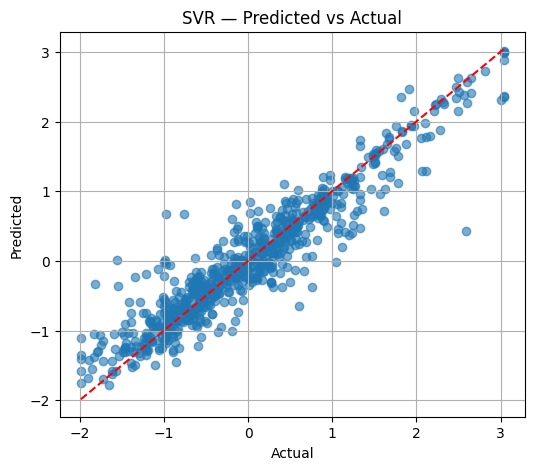

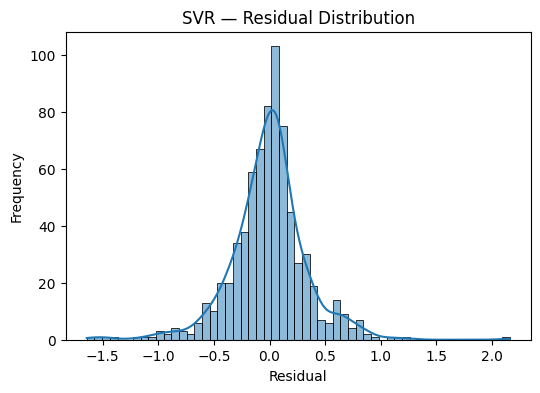

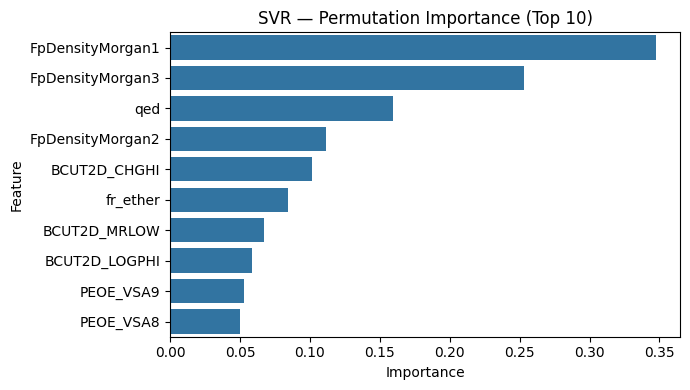


🔹 Training MLPRegressor...


Fitting MLPRegressor: 100%|███████████████████████████████████████████| 1/1 [00:04<00:00,  4.70s/it]


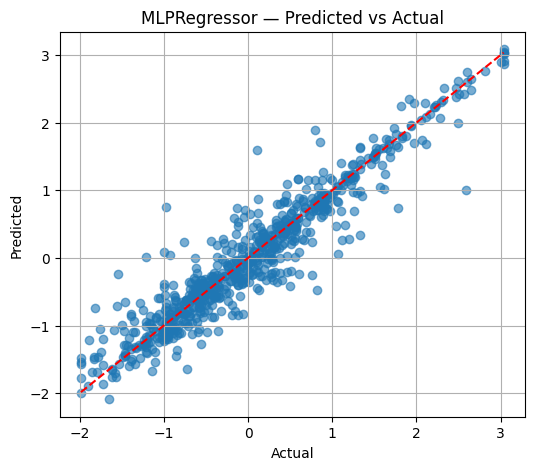

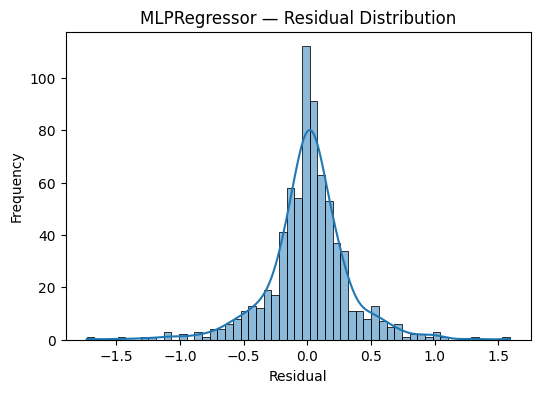

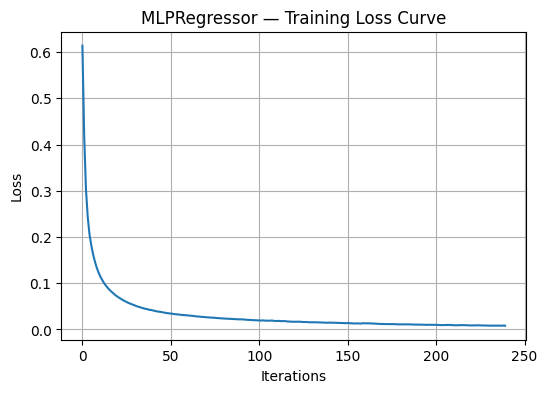

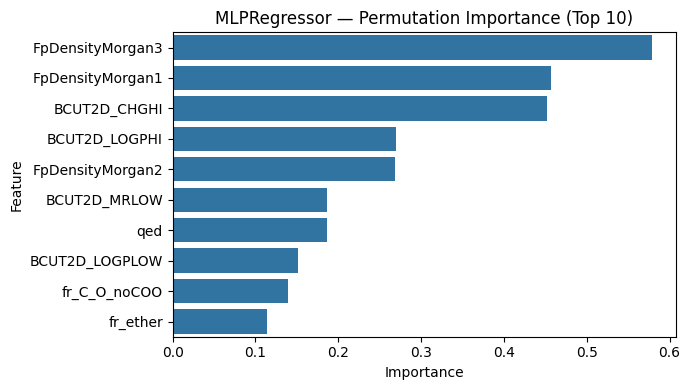


🔹 Training Ridge...


Fitting Ridge: 100%|█████████████████████████████████████████████████| 1/1 [00:00<00:00, 124.49it/s]


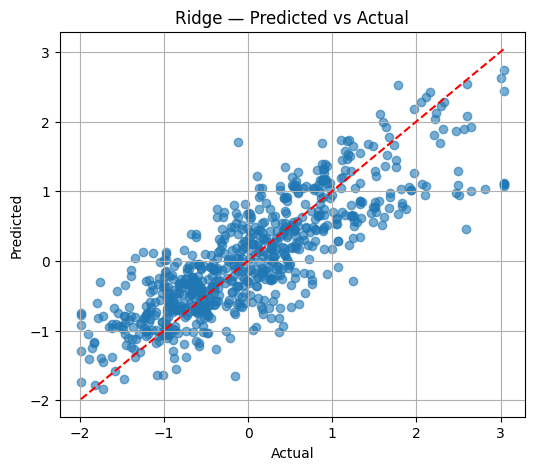

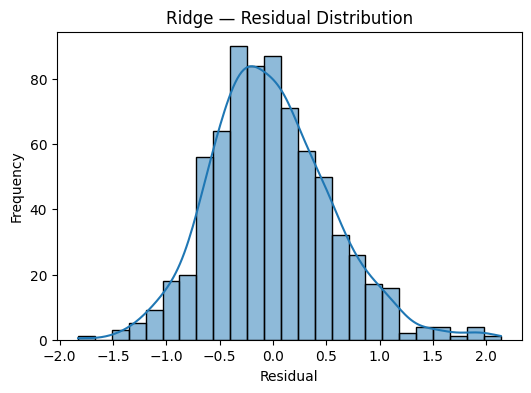

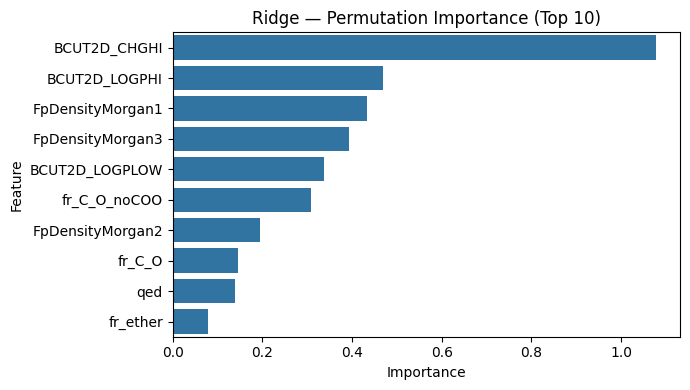


🔹 Training Lasso...


Fitting Lasso: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.77it/s]


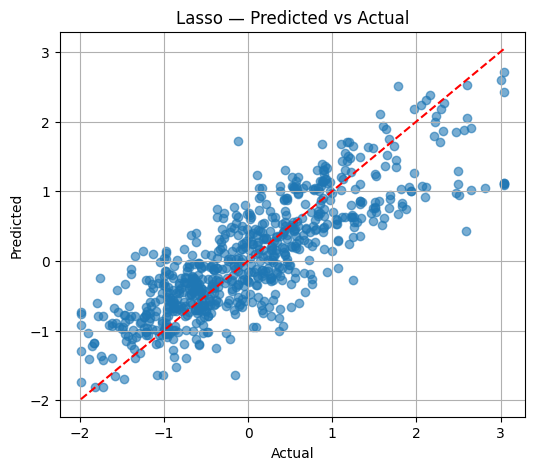

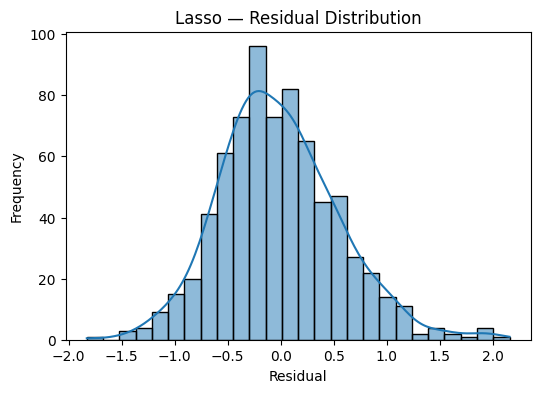

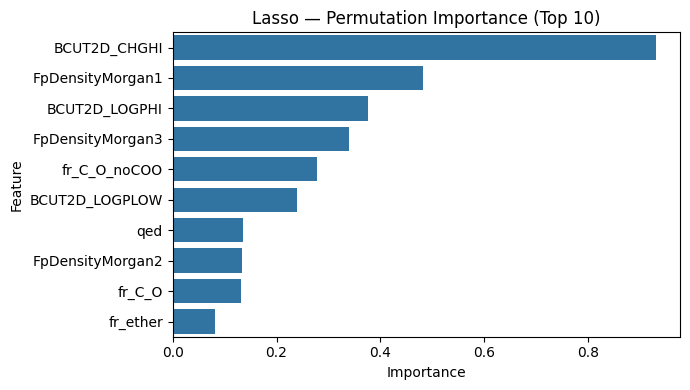


🔹 Training ElasticNet...


Fitting ElasticNet: 100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.85it/s]


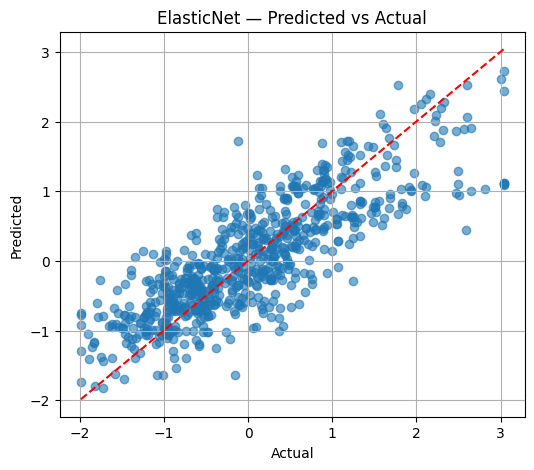

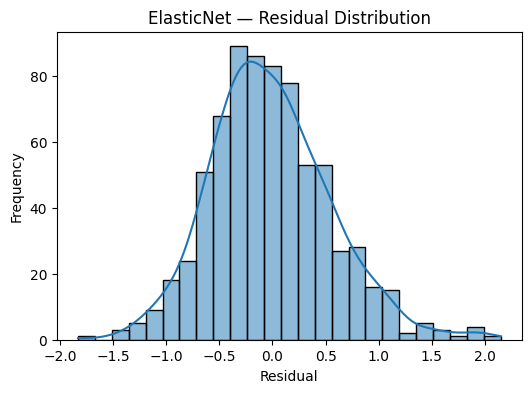

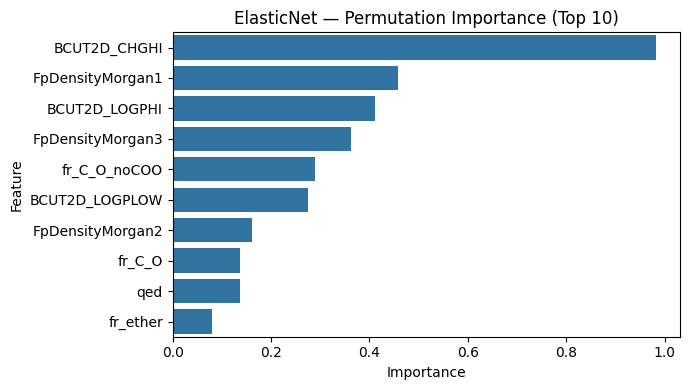


🔹 Training XGBRegressor...


Fitting XGBRegressor: 100%|███████████████████████████████████████████| 1/1 [00:01<00:00,  1.37s/it]


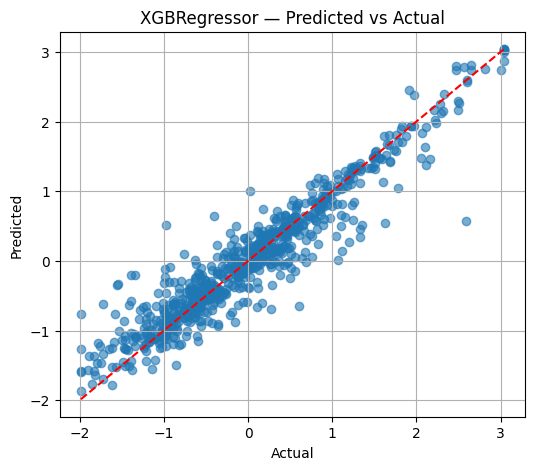

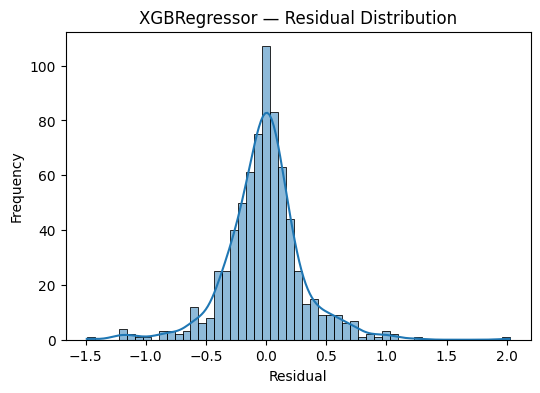

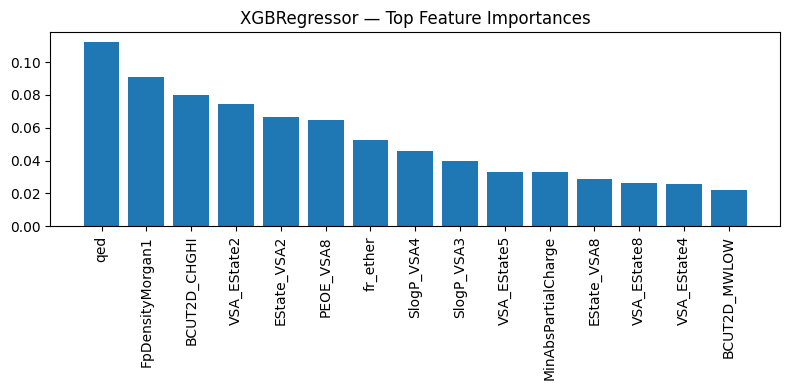

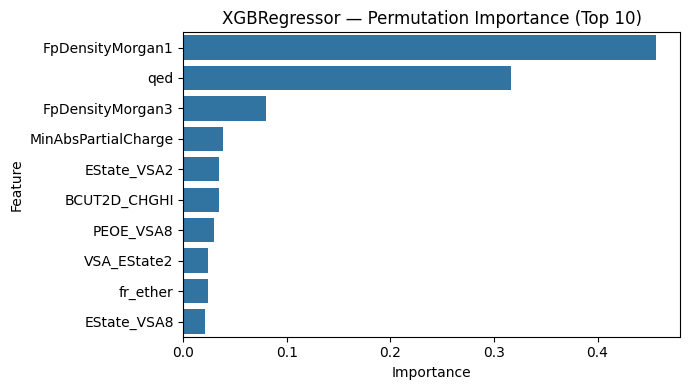


🔹 Training LGBMRegressor...


Fitting LGBMRegressor:   0%|                                                  | 0/1 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000308 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4275
[LightGBM] [Info] Number of data points in the train set: 1687, number of used features: 30
[LightGBM] [Info] Start training from score -0.008457


Fitting LGBMRegressor: 100%|██████████████████████████████████████████| 1/1 [00:00<00:00,  1.20it/s]


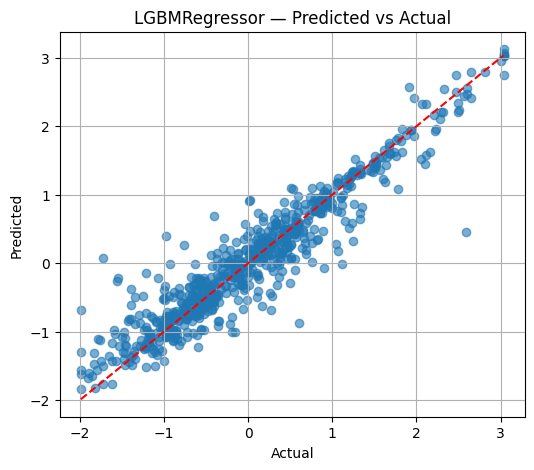

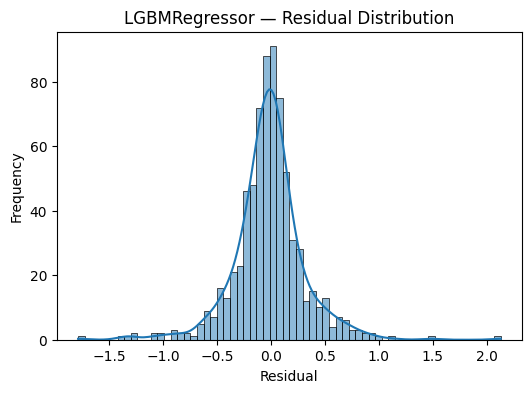

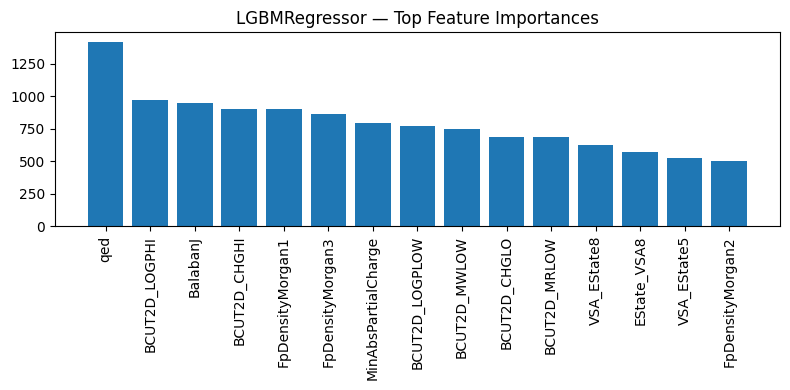

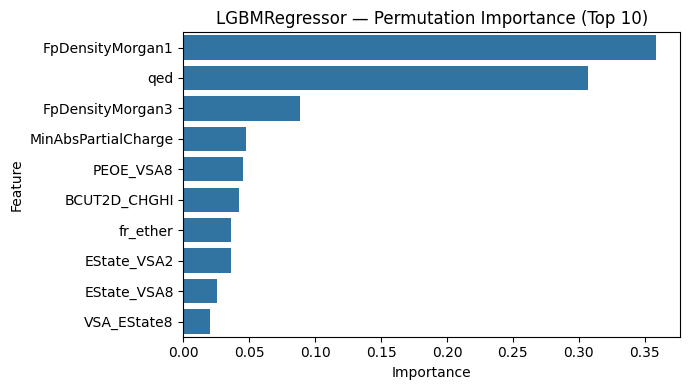


🔹 Training CatBoostRegressor...


Fitting CatBoostRegressor: 100%|██████████████████████████████████████| 1/1 [00:04<00:00,  4.14s/it]


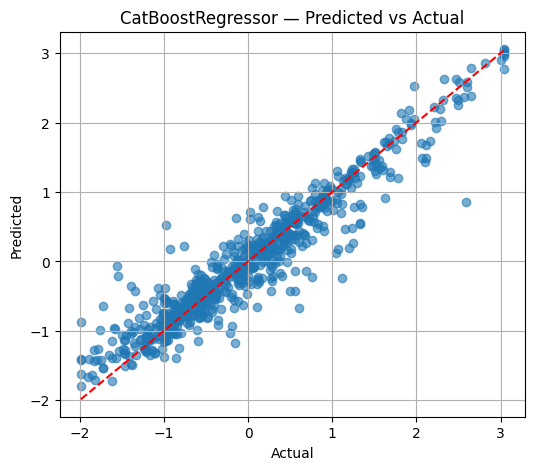

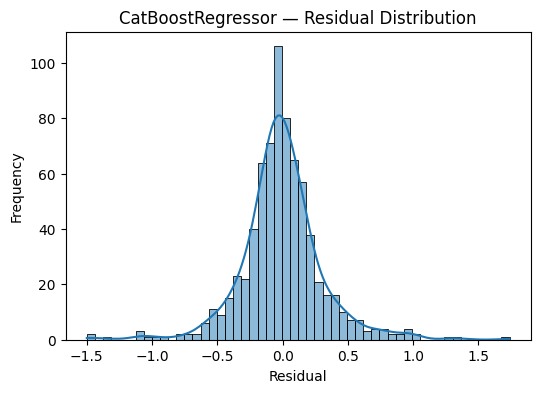

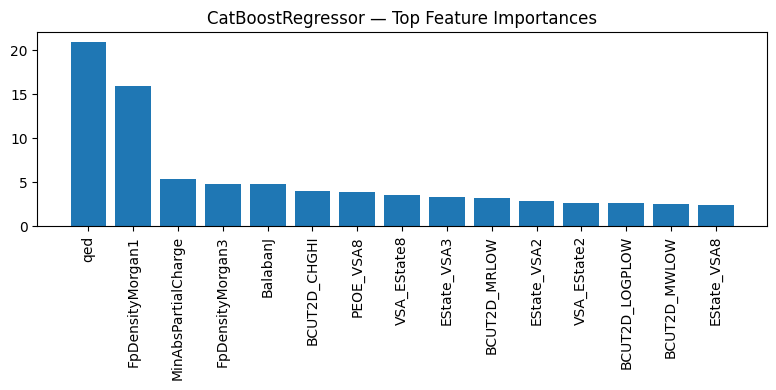

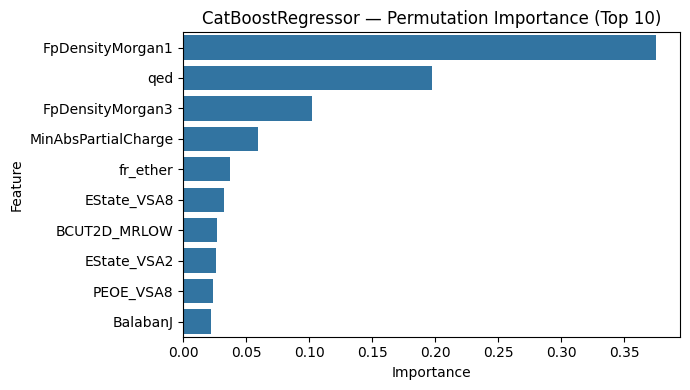

Model  Train_R2  Train_RMSE  Train_MAE   Test_R2  \
0            LinearRegression  0.653478    0.585676   0.452907  0.687673   
1       RandomForestRegressor  0.981759    0.134375   0.094174  0.852492   
2   GradientBoostingRegressor  0.907779    0.302139   0.228830  0.855145   
3                         SVR  0.942505    0.238565   0.159861  0.882355   
4                MLPRegressor  0.984002    0.125842   0.090644  0.898962   
5                       Ridge  0.653445    0.585704   0.452805  0.687691   
6                       Lasso  0.652998    0.586082   0.452604  0.687309   
7                  ElasticNet  0.653246    0.585872   0.452639  0.687557   
8                XGBRegressor  0.997908    0.045507   0.031637  0.897266   
9               LGBMRegressor  0.997306    0.051639   0.036851  0.893270   
10          CatBoostRegressor  0.988842    0.105095   0.079061  0.903241   

    Test_RMSE  Test_MAE  
0    0.565267  0.442497  
1    0.388469  0.263812  
2    0.384960  0.283079  
3    0.346925  0.239473  
4    0.321508  0.216593  
5    0.565250  0.442391  
6    0.565596  0.442539  
7    0.565371  0.442415  
8    0.324194  0.221453  
9    0.330439  0.222675  
10   0.314626  0.213825

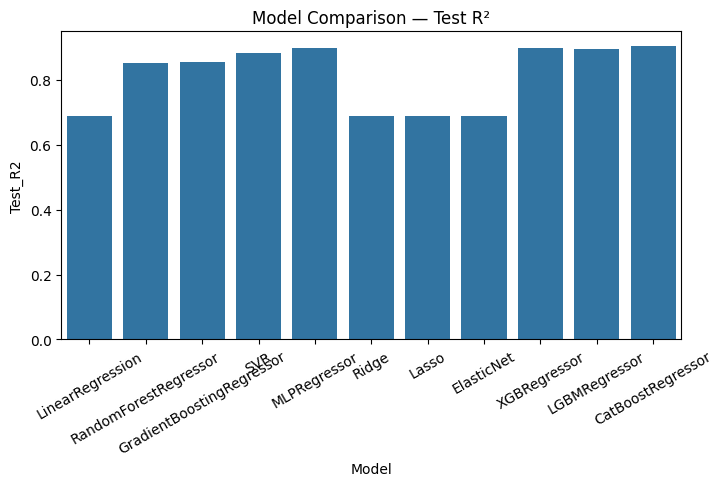

In [32]:
# -------------------------------------------
# Data split
# -------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=42)

# -------------------------------------------
# Helper function for metrics
# -------------------------------------------
def get_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = math.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return {"R2": r2, "RMSE": rmse, "MAE": mae}

# -------------------------------------------
# Training loop
# -------------------------------------------
results = []

for model in models:
    model_name = model.__class__.__name__
    print(f"\n🔹 Training {model_name}...")

    # tqdm progress for fit (especially for iterative models)
    pbar = tqdm(total=1, desc=f"Fitting {model_name}", ncols=100, colour="cyan")
    model.fit(X_train, y_train)
    pbar.update(1)
    pbar.close()

    # Predictions
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    # Metrics
    train_metrics = get_metrics(y_train, y_pred_train)
    test_metrics = get_metrics(y_test, y_pred_test)
    results.append({
        "Model": model_name,
        **{f"Train_{k}": v for k, v in train_metrics.items()},
        **{f"Test_{k}": v for k, v in test_metrics.items()}
    })

    # -------------------------------------------
    # 📈 Plot 1: Predicted vs Actual
    # -------------------------------------------
    plt.figure(figsize=(6, 5))
    plt.scatter(y_test, y_pred_test, alpha=0.6)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.title(f"{model_name} — Predicted vs Actual")
    plt.grid(True)
    plt.show()

    # -------------------------------------------
    # 📉 Plot 2: Residual Plot
    # -------------------------------------------
    residuals = y_test - y_pred_test
    plt.figure(figsize=(6, 4))
    sns.histplot(residuals, kde=True)
    plt.title(f"{model_name} — Residual Distribution")
    plt.xlabel("Residual")
    plt.ylabel("Frequency")
    plt.show()

    # -------------------------------------------
    # 📊 Plot 3: Feature Importance (for tree models)
    # -------------------------------------------
    if hasattr(model, "feature_importances_"):
        importances = model.feature_importances_
        indices = np.argsort(importances)[::-1][:15]  # top 15
        plt.figure(figsize=(8, 4))
        plt.bar(range(len(indices)), importances[indices], align='center')
        plt.xticks(range(len(indices)), np.array(X_train.columns)[indices], rotation=90)
        plt.title(f"{model_name} — Top Feature Importances")
        plt.tight_layout()
        plt.show()

    # -------------------------------------------
    # 📉 Plot 4: Loss Curve (if available)
    # -------------------------------------------
    if hasattr(model, "loss_curve_"):
        plt.figure(figsize=(6, 4))
        plt.plot(model.loss_curve_)
        plt.title(f"{model_name} — Training Loss Curve")
        plt.xlabel("Iterations")
        plt.ylabel("Loss")
        plt.grid(True)
        plt.show()

    # -------------------------------------------
    # 📈 Plot 5: Permutation Importance (for all models)
    # -------------------------------------------
    try:
        perm_importance = permutation_importance(model, X_test, y_test, n_repeats=5, random_state=0)
        perm_df = pd.DataFrame({
            'Feature': X_train.columns,
            'Importance': perm_importance['importances_mean']
        }).sort_values(by='Importance', ascending=False).head(10)

        plt.figure(figsize=(7, 4))
        sns.barplot(x='Importance', y='Feature', data=perm_df)
        plt.title(f"{model_name} — Permutation Importance (Top 10)")
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"⚠️ Skipping permutation importance for {model_name}: {e}")

# -------------------------------------------
# 📊 Summary of All Models
# -------------------------------------------
results_df = pd.DataFrame(results)
display(results_df)

plt.figure(figsize=(8, 4))
sns.barplot(x="Model", y="Test_R2", data=results_df)
plt.title("Model Comparison — Test R²")
plt.xticks(rotation=30)
plt.show()


In [33]:
results_df.to_csv('target_log_dvap_scaled.csv', index=False)

### Comparison of scalling and not scalling model 

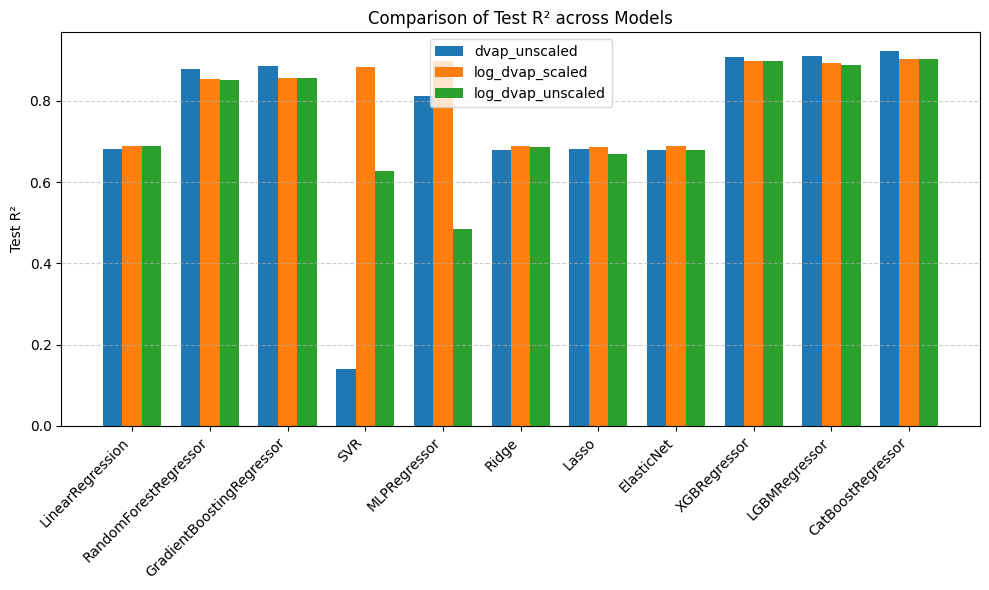

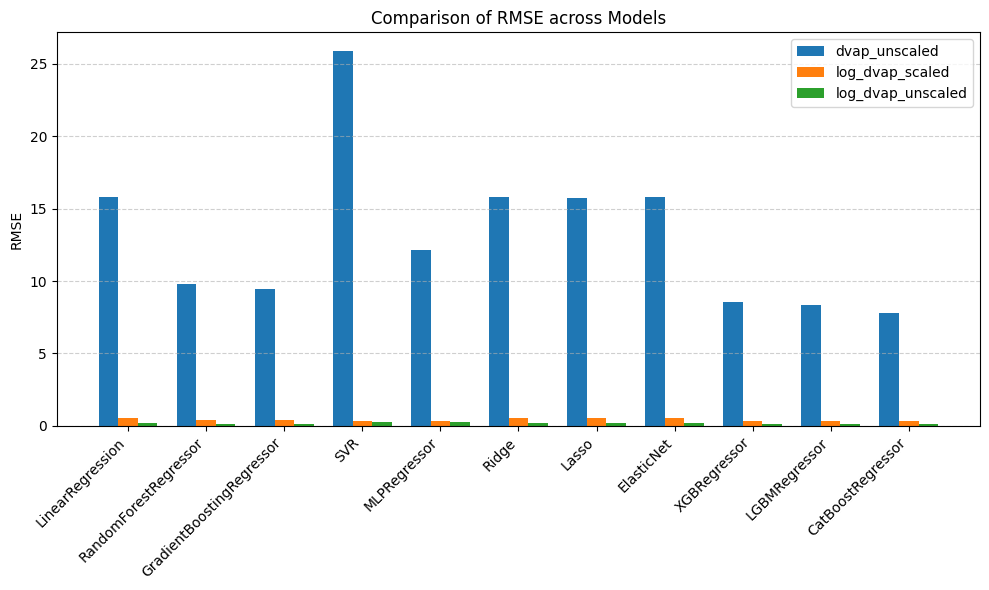

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# --- Load results ---
dvap_unscaled = pd.read_csv('target_dvap_unscaled.csv')
log_dvap_scaled = pd.read_csv('target_log_dvap_scaled.csv')
log_dvap_unscaled = pd.read_csv('target_log_dvap_unscaled.csv')

# --- Common assumption: all CSVs have same "Model" column (or similar) ---
# Replace 'Model' with the actual column name if different
models = dvap_unscaled['Model']

# --- Extract Test R² and RMSE from all three ---
metrics = pd.DataFrame({
    'Model': models,
    'dvap_unscaled_R2': dvap_unscaled['Test_R2'],
    'log_dvap_scaled_R2': log_dvap_scaled['Test_R2'],
    'log_dvap_unscaled_R2': log_dvap_unscaled['Test_R2'],
    'dvap_unscaled_RMSE': dvap_unscaled['Test_RMSE'],
    'log_dvap_scaled_RMSE': log_dvap_scaled['Test_RMSE'],
    'log_dvap_unscaled_RMSE': log_dvap_unscaled['Test_RMSE']
})

# --- Set up x-axis positions ---
x = np.arange(len(metrics['Model']))
bar_width = 0.25

# === Plot 1: Test R² comparison ===
plt.figure(figsize=(10, 6))
plt.bar(x - bar_width, metrics['dvap_unscaled_R2'], width=bar_width, label='dvap_unscaled')
plt.bar(x, metrics['log_dvap_scaled_R2'], width=bar_width, label='log_dvap_scaled')
plt.bar(x + bar_width, metrics['log_dvap_unscaled_R2'], width=bar_width, label='log_dvap_unscaled')

plt.xticks(x, metrics['Model'], rotation=45, ha='right')
plt.ylabel('Test R²')
plt.title('Comparison of Test R² across Models')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# === Plot 2: RMSE comparison ===
plt.figure(figsize=(10, 6))
plt.bar(x - bar_width, metrics['dvap_unscaled_RMSE'], width=bar_width, label='dvap_unscaled')
plt.bar(x, metrics['log_dvap_scaled_RMSE'], width=bar_width, label='log_dvap_scaled')
plt.bar(x + bar_width, metrics['log_dvap_unscaled_RMSE'], width=bar_width, label='log_dvap_unscaled')

plt.xticks(x, metrics['Model'], rotation=45, ha='right')
plt.ylabel('RMSE')
plt.title('Comparison of RMSE across Models')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()
